# Final results - regional + constraint
This notebook will be used to compare results from original runs for regional and constraint modes, given new process for identifying specific resources
- previous runs sampled resources for the centroid of a given region
- new resource locations based on 'best in area' determined by reV team that considers exclusions and lcoe, distance to transmission etc.

Methodology for the new reV method can be found in paper.

Code here taken from the notebook `Paper_values_figures_update.ipynb`

In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
import math
import numpy as np

import vapor
from vapor.models import Cambium

2021-04-22 13:09:24,286 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
os.getcwd()

'/lustre/eaglefs/projects/vapor/vapor-open'

## Original results

In [46]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results',file)
                    dfs.append(pd.read_pickle(fp))


results_orig = pd.concat(dfs, axis='rows')
results_orig.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df_orig = results_orig.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df_orig.sort_values(opt_vars[0], inplace=True)
df_orig.drop_duplicates(['scenario','state','tech','batt_size'], inplace=True) #keep best performing system by region/scenario

# --- Clean up ---
df_orig['lifetime_cambium_co2_rate_avg_mwh'] = df_orig['lifetime_cambium_co2_rate_avg'] / df_orig['lifetime_output_mwh']
df_orig['lifetime_cambium_co2_rate_avg_mw'] = df_orig['lifetime_cambium_co2_rate_avg'] / df_orig['system_capacity']
df_orig['lifetime_cambium_co2_rate_lrmer_mwh'] = df_orig['lifetime_cambium_co2_rate_lrmer'] / df_orig['lifetime_output_mwh']
df_orig['lifetime_cambium_co2_rate_lrmer_mw'] = df_orig['lifetime_cambium_co2_rate_lrmer'] / df_orig['system_capacity']
df_orig['lifetime_cambium_grid_value'] = df_orig['lifetime_cambium_grid_value'] / df_orig['system_capacity']

df_orig.head()

adjusted_installed_cost  analysis_period_irr  cash_for_debt_service  \
3092             2.751567e+08                  NaN          -2.618369e+08   
5228             2.751567e+08                  NaN          -2.522835e+08   
955              2.751567e+08                  NaN          -2.433029e+08   
4150             2.931684e+08                  NaN          -1.787634e+08   
3944             3.032650e+08                  NaN          -1.659582e+08   

      cbi_fedtax_total  cbi_statax_total  cbi_total  cbi_total_fed  \
3092               0.0               0.0        0.0            0.0   
5228               0.0               0.0        0.0            0.0   
955                0.0               0.0        0.0            0.0   
4150               0.0               0.0        0.0            0.0   
3944               0.0               0.0        0.0            0.0   

      cbi_total_oth  cbi_total_sta  cbi_total_uti  ...  env_losses  \
3092            0.0            0.0            0.0  ...         NaN   
5228            0.0            0.0            0.0  ...         NaN   
955             0.0            0.0            0.0  ...         NaN   
4150            0.0            0.0            0.0  ...    5.578702   
3944            0.0            0.0            0.0  ...    5.578702   

      ops_losses  turb_losses  wake_losses  wind_speed_average  turbine_class  \
3092         NaN          NaN          NaN                 NaN            NaN   
5228         NaN          NaN          NaN                 NaN            NaN   
955          NaN          NaN          NaN                 NaN            NaN   
4150    2.803467     3.954496    11.930601            4.625302            4.0   
3944    2.803467     3.954496    20.077163            3.622347            4.0   

      wind_turbine_hub_ht  state  lifetime_cambium_co2_rate_avg_mw  \
3092                  NaN     TX                       5093.072296   
5228                  NaN     TX                       5631.630387   
955                   NaN     TX                       6868.723315   
4150           139.235694     AR                       1278.946134   
3944           139.235694     CA                       1284.745408   

      lifetime_cambium_co2_rate_lrmer_mw  
3092                         9319.837224  
5228                         9154.598935  
955                         11762.892953  
4150                         1239.443375  
3944                          786.081012  

[5 rows x 623 columns]

## New results

In [47]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results', 'best_by_region',file)
                    dfs.append(pd.read_pickle(fp))


results_new = pd.concat(dfs, axis='rows')
results_new.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df_new = results_new.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by pca ---
df_new.sort_values(opt_vars[0], inplace=True)
df_new.drop_duplicates(['scenario','state','tech','batt_size'], inplace=True) #keep best performing system by region/scenario

# --- Clean up ---
df_new['lifetime_cambium_co2_rate_avg_mwh'] = df_new['lifetime_cambium_co2_rate_avg'] / df_new['lifetime_output_mwh']
df_new['lifetime_cambium_co2_rate_avg_mw'] = df_new['lifetime_cambium_co2_rate_avg'] / df_new['system_capacity']
df_new['lifetime_cambium_co2_rate_lrmer_mwh'] = df_new['lifetime_cambium_co2_rate_lrmer'] / df_new['lifetime_output_mwh']
df_new['lifetime_cambium_co2_rate_lrmer_mw'] = df_new['lifetime_cambium_co2_rate_lrmer'] / df_new['system_capacity']
df_new['lifetime_cambium_grid_value'] = df_new['lifetime_cambium_grid_value'] / df_new['system_capacity']

df_new.head()

adjusted_installed_cost  analysis_period_irr  cash_for_debt_service  \
2857             2.979528e+08                  NaN          -1.990883e+08   
4994             2.979528e+08                  NaN          -1.907162e+08   
723              2.979528e+08                  NaN          -1.887066e+08   
2996             2.764601e+08                  NaN          -2.398324e+08   
859              2.764601e+08                  NaN          -2.320752e+08   

      cbi_fedtax_total  cbi_statax_total  cbi_total  cbi_total_fed  \
2857               0.0               0.0        0.0            0.0   
4994               0.0               0.0        0.0            0.0   
723                0.0               0.0        0.0            0.0   
2996               0.0               0.0        0.0            0.0   
859                0.0               0.0        0.0            0.0   

      cbi_total_oth  cbi_total_sta  cbi_total_uti  ...  env_losses  \
2857            0.0            0.0            0.0  ...         NaN   
4994            0.0            0.0            0.0  ...         NaN   
723             0.0            0.0            0.0  ...         NaN   
2996            0.0            0.0            0.0  ...         NaN   
859             0.0            0.0            0.0  ...         NaN   

      ops_losses  turb_losses  wake_losses  wind_speed_average  turbine_class  \
2857         NaN          NaN          NaN                 NaN            NaN   
4994         NaN          NaN          NaN                 NaN            NaN   
723          NaN          NaN          NaN                 NaN            NaN   
2996         NaN          NaN          NaN                 NaN            NaN   
859          NaN          NaN          NaN                 NaN            NaN   

      wind_turbine_hub_ht  state  lifetime_cambium_co2_rate_avg_mw  \
2857                  NaN     CA                       5464.797911   
4994                  NaN     CA                       5669.881732   
723                   NaN     CA                       5793.815227   
2996                  NaN     AZ                      32433.762353   
859                   NaN     AZ                      33347.879912   

      lifetime_cambium_co2_rate_lrmer_mw  
2857                         3134.603091  
4994                         3578.321602  
723                          3758.040989  
2996                        29228.865240  
859                         32240.305204  

[5 rows x 623 columns]

### Oddity
Something is happening where not every region-scenario-battery size-technology pair is appearing in final results, may be due to "drop duplicates" in code above ...

I think this is because I am looking at results at a pca level, but duplicates are dropped at the state level. Commenting out the drop_duplicates piece causes no missing values. Likewise organizing values by state rather than pc yields 2 values (one for each tech) for each state-scenario-batt size combination

In [49]:
df_orig.groupby(['state','scenario', 'batt_size'], as_index=False)['lifetime_output_mwh'].count()
# df_orig.loc[(df_orig.region == 'p1') & (df_orig.scenario == 'StdScen20_HighRECost') & (df_orig.batt_size == 25)][['tech', 'lifetime_output_mwh']]

state              scenario  batt_size  lifetime_output_mwh
0      AL  StdScen20_HighRECost        0.0                    2
1      AL  StdScen20_HighRECost       25.0                    2
2      AL  StdScen20_HighRECost      100.0                    2
3      AL   StdScen20_LowRECost        0.0                    2
4      AL   StdScen20_LowRECost       25.0                    2
..    ...                   ...        ...                  ...
427    WY   StdScen20_LowRECost       25.0                    2
428    WY   StdScen20_LowRECost      100.0                    2
429    WY     StdScen20_MidCase        0.0                    2
430    WY     StdScen20_MidCase       25.0                    2
431    WY     StdScen20_MidCase      100.0                    2

[432 rows x 4 columns]

### Checking generation between results

In general, it is fair to say that the new method led to an increase in the lifetime generation of wind systems with a very modest decrease on average for solar PV systems. 

The median generation percentage increase for wind was ~50% and for solar PV it was -2%. Generation decreases across both wind and solar PV might potentially be caused by land exclusions. Most decreases were modest, between 0 and -10%.

In [83]:
temp_df_check_gen_orig = df_orig[['state','scenario', 'batt_size', 'tech','lifetime_output_mwh']]
temp_df_check_gen_new = df_new[['state','scenario', 'batt_size', 'tech','lifetime_output_mwh']]
temp_df_check_gen = temp_df_check_gen_orig.merge(temp_df_check_gen_new,\
                                                 on = ['state','scenario', 'batt_size', 'tech'],\
                                                 suffixes=('_orig', '_new'))
temp_df_check_gen['gen_change'] = ((temp_df_check_gen['lifetime_output_mwh_new'] - temp_df_check_gen['lifetime_output_mwh_orig'])/(temp_df_check_gen['lifetime_output_mwh_orig']))*100
temp_df_check_gen.head(10)

state              scenario  batt_size  tech  lifetime_output_mwh_orig  \
0    TX   StdScen20_LowRECost      100.0    pv              3.398995e+06   
1    TX     StdScen20_MidCase      100.0    pv              3.400024e+06   
2    TX  StdScen20_HighRECost      100.0    pv              3.400780e+06   
3    AR   StdScen20_LowRECost      100.0  wind              5.060472e+05   
4    CA   StdScen20_LowRECost      100.0  wind              6.606957e+05   
5    CA     StdScen20_MidCase      100.0  wind              6.606957e+05   
6    CA  StdScen20_HighRECost      100.0  wind              6.606957e+05   
7    AR     StdScen20_MidCase      100.0  wind              5.060472e+05   
8    AR  StdScen20_HighRECost      100.0  wind              5.060472e+05   
9    WA   StdScen20_LowRECost      100.0  wind              7.328453e+05   

   lifetime_output_mwh_new  gen_change  
0             2.197467e+06  -35.349522  
1             2.037257e+06  -40.081095  
2             2.043117e+06  -39.922085  
3             4.326304e+06  754.921130  
4             2.219178e+06  235.885053  
5             2.219178e+06  235.885053  
6             2.219178e+06  235.885053  
7             3.252919e+06  542.809488  
8             3.252919e+06  542.809488  
9             2.772084e+06  278.263177

In [84]:
temp_df_check_gen.pivot(index=['state', 'scenario', 'batt_size'], columns='tech', values='gen_change').reset_index()[['pv', 'wind']].quantile(q=[i/100 for i in range(101) if i % 5==0])

tech         pv        wind
0.00 -40.081095  -25.512755
0.05 -10.164931    5.906694
0.10  -7.337959   10.214659
0.15  -6.532491   17.606396
0.20  -5.635510   23.170494
0.25  -5.096180   27.790548
0.30  -4.625133   29.407007
0.35  -4.137161   31.291909
0.40  -3.413488   42.876643
0.45  -2.806511   48.157800
0.50  -2.034207   53.573653
0.55  -0.964672   64.228576
0.60  -0.458016   74.580447
0.65   0.450155   85.540872
0.70   1.785052   93.422139
0.75   2.845008  150.752682
0.80   3.934962  155.172614
0.85   5.190429  160.183552
0.90   7.532849  201.159903
0.95  12.936190  275.440955
1.00  63.054949  754.921130

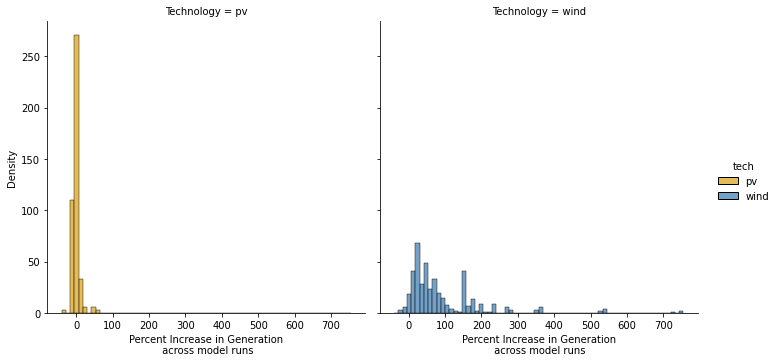

In [133]:
g = sns.displot(data=temp_df_check_gen, x="gen_change", hue="tech", col="tech", kind="hist",\
                palette = {"pv": "goldenrod", "wind": "steelblue"})
g.set_axis_labels("Percent Increase in Generation\n across model runs","Density")
g.set_titles("Technology = {col_name}")

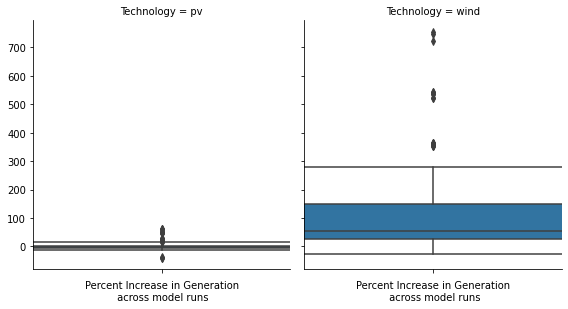

In [135]:
g = sns.catplot(y="gen_change", hue="tech", col="tech",
                data=temp_df_check_gen, kind="box",
#                 palette = {"pv": "goldenrod", "wind": "steelblue"},
                height=4, width=18)
g.set_axis_labels("Percent Increase in Generation\n across model runs", "")
g.set_titles("Technology = {col_name}")

In [110]:
import geopandas as gpd
map_file = gpd.read_file(os.path.join('geography', 'ReEDS_Resource_Regions.shp'))[['state', 'geometry']]
map_file = map_file.dissolve('state')

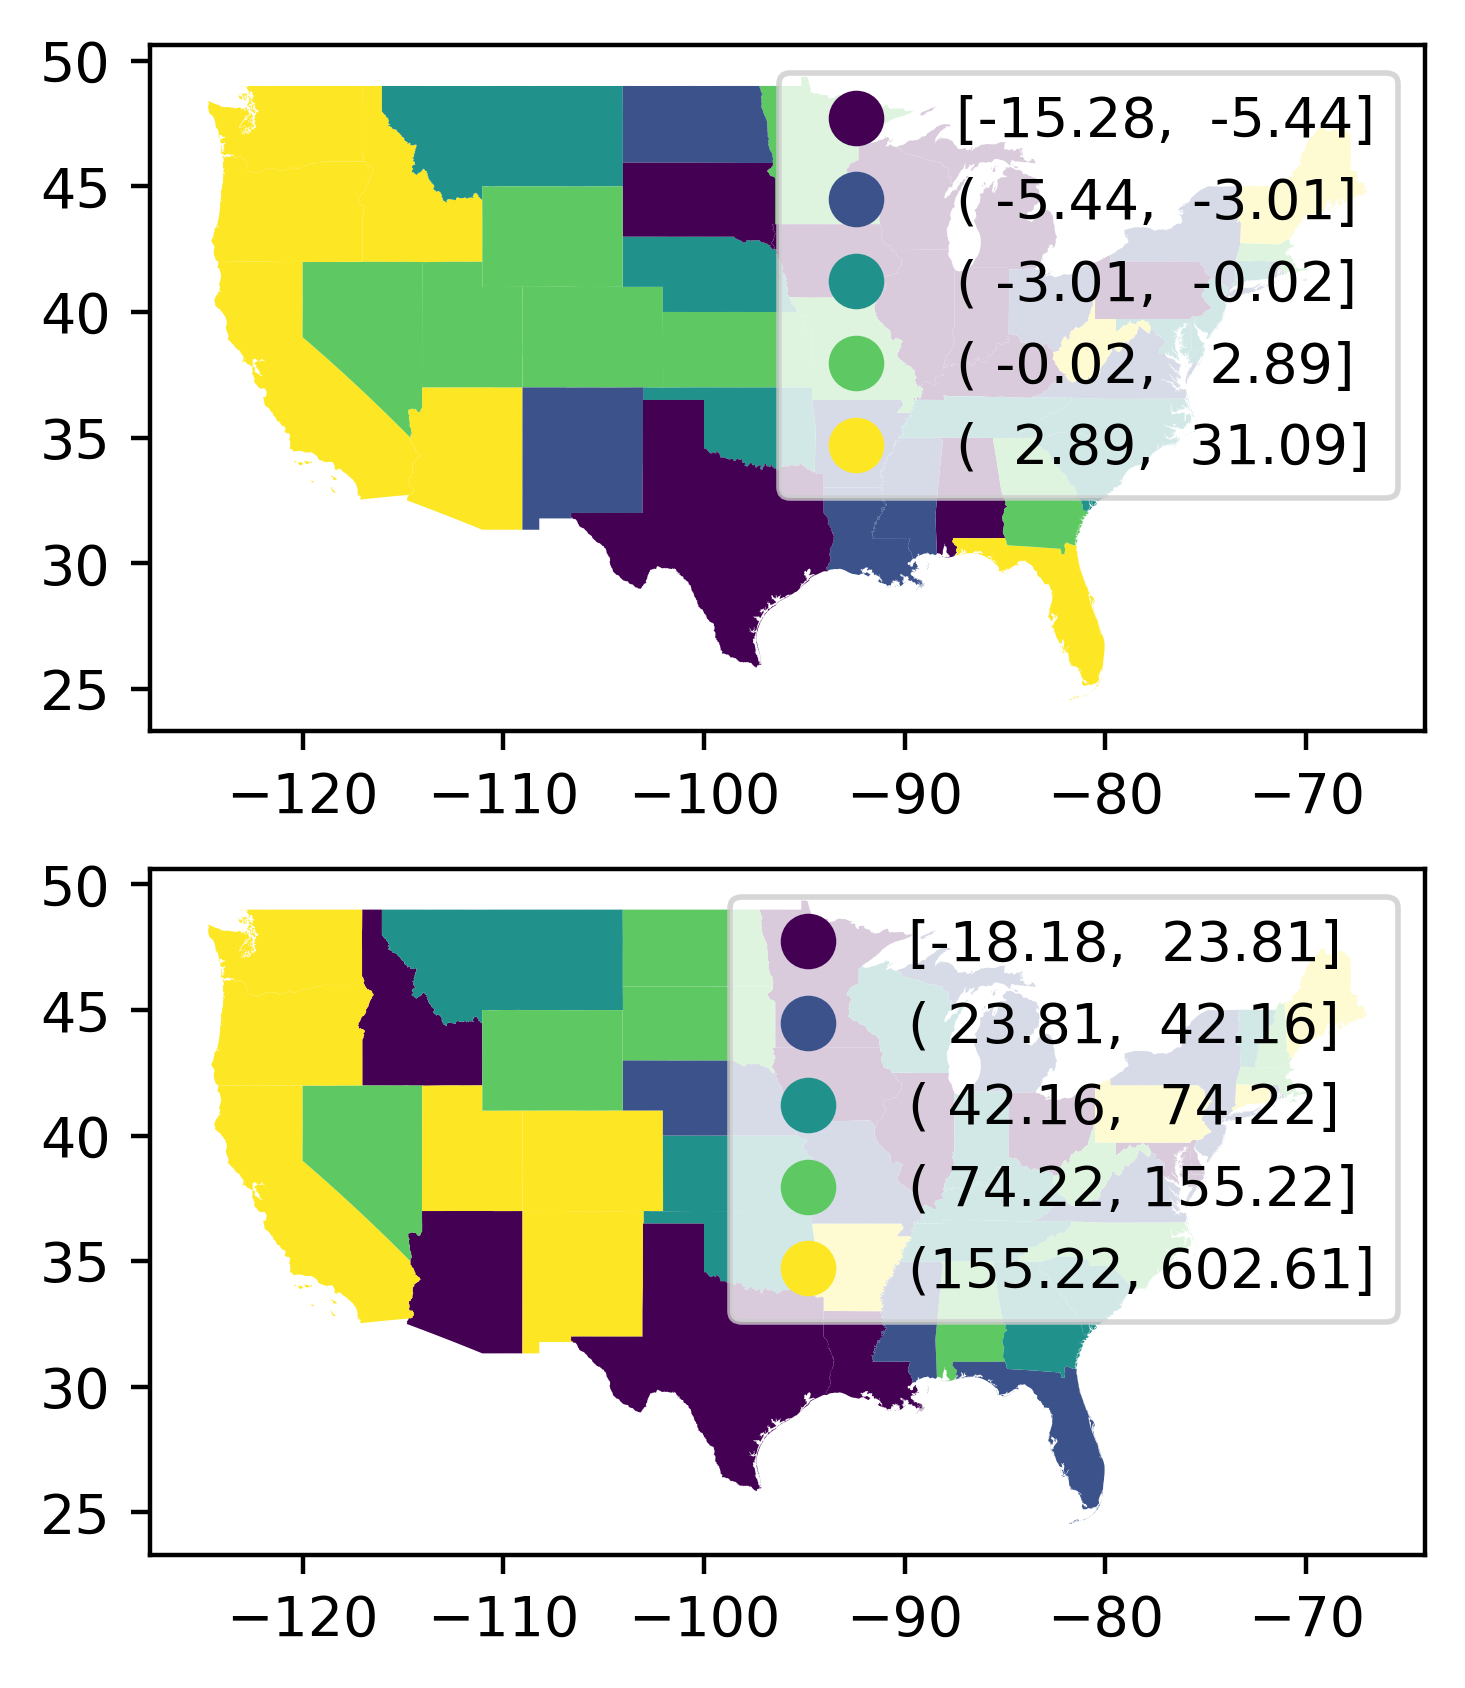

In [115]:
temp_df_check_gen_map = temp_df_check_gen[['state', 'tech', 'gen_change']].groupby(['tech','state'], as_index=False)['gen_change'].mean()
temp_df_check_gen_map.head()
plot_file = map_file.merge(temp_df_check_gen_map, on=['state'])

fig, axs = plt.subplots(nrows=2, figsize=(9, 5), dpi=400)

axs_count = 0
for tech in ['pv','wind']:
    plot_data = plot_file.loc[(plot_file.tech == tech)]
#     print(plot_data.head())
    plot_data.plot(ax=axs[axs_count], column='gen_change', legend=True, scheme='Quantiles')
#     ax.set_axis_off()
#     ax.set_title(f"Average Change in Generation - {tech}")
#     plt.axis('equal')
#     plt.show()
    axs_count += 1

### Checking lifetime values between results
The original results (may) have the scaling issue that was corrected in the repos, but not necessarily re-run. I will stick to lifetime values as this avoids the scaling issue entirely.

Same pattern emerges as with generation, lifetime revenues (scaled by capacity, so $/MW) are typically higher under the new resource sampling, with the median increase equal to a ~30% increase

In [119]:
temp_df_check_revenues_orig = df_orig[['state','scenario', 'batt_size', 'tech','lifetime_cambium_grid_value']]
temp_df_check_revenues_new = df_new[['state','scenario', 'batt_size', 'tech','lifetime_cambium_grid_value']]
temp_df_check_revenues = temp_df_check_revenues_orig.merge(temp_df_check_revenues_new,\
                                                 on = ['state','scenario', 'batt_size', 'tech'],\
                                                 suffixes=('_orig', '_new'))
temp_df_check_revenues['revenue_change'] = ((temp_df_check_revenues['lifetime_cambium_grid_value_new'] - temp_df_check_revenues['lifetime_cambium_grid_value_orig'])/(temp_df_check_revenues['lifetime_cambium_grid_value_orig']))*100
temp_df_check_revenues.head()

state              scenario  batt_size  tech  \
0    TX   StdScen20_LowRECost      100.0    pv   
1    TX     StdScen20_MidCase      100.0    pv   
2    TX  StdScen20_HighRECost      100.0    pv   
3    AR   StdScen20_LowRECost      100.0  wind   
4    CA   StdScen20_LowRECost      100.0  wind   

   lifetime_cambium_grid_value_orig  lifetime_cambium_grid_value_new  \
0                        924.645524                       667.881191   
1                       1020.218625                       674.199966   
2                       1110.021101                       647.372315   
3                        106.003719                       773.478780   
4                        224.339848                       780.272645   

   revenue_change  
0      -27.768948  
1      -33.916128  
2      -41.679279  
3      629.671364  
4      247.808315

In [123]:
temp_df_check_revenues.pivot(index=['state', 'scenario', 'batt_size'], columns='tech', values='revenue_change').reset_index()[['pv', 'wind']].quantile(q=[i/100 for i in range(101) if i % 5==0])

tech          pv        wind
0.00  -41.679279   -0.574001
0.05   -7.780100    6.275388
0.10   -3.088605   14.807923
0.15    0.755405   18.187318
0.20    4.696063   20.710746
0.25    7.974228   24.510463
0.30   11.055158   28.626366
0.35   14.269509   31.503946
0.40   16.575480   43.345439
0.45   19.917649   48.286745
0.50   22.488455   55.662955
0.55   25.885736   65.833679
0.60   29.768162   77.635539
0.65   33.338459   86.473961
0.70   37.083727  104.938384
0.75   41.086253  131.252250
0.80   48.975215  153.974849
0.85   53.336346  167.862919
0.90   62.287939  209.522690
0.95   75.409034  254.234382
1.00  156.986636  669.108843

In [132]:
g = sns.displot(data=temp_df_check_revenues, x="revenue_change", hue="tech", col="tech", kind="hist",\
                palette = {"pv": "goldenrod", "wind": "steelblue"})
g.set_axis_labels("Percent Increase in Revenues\n across model runs","Density")
g.set_titles("Technology = {col_name}")

In [136]:
g = sns.catplot(y="revenue_change", hue="tech", col="tech",
                data=temp_df_check_revenues, kind="box",
#                 palette = {"pv": "goldenrod", "wind": "steelblue"},
                height=4, width=18)
g.set_axis_labels("Percent Increase in Revenues\n across model runs", "")
g.set_titles("Technology = {col_name}")


### Checking emissions between results

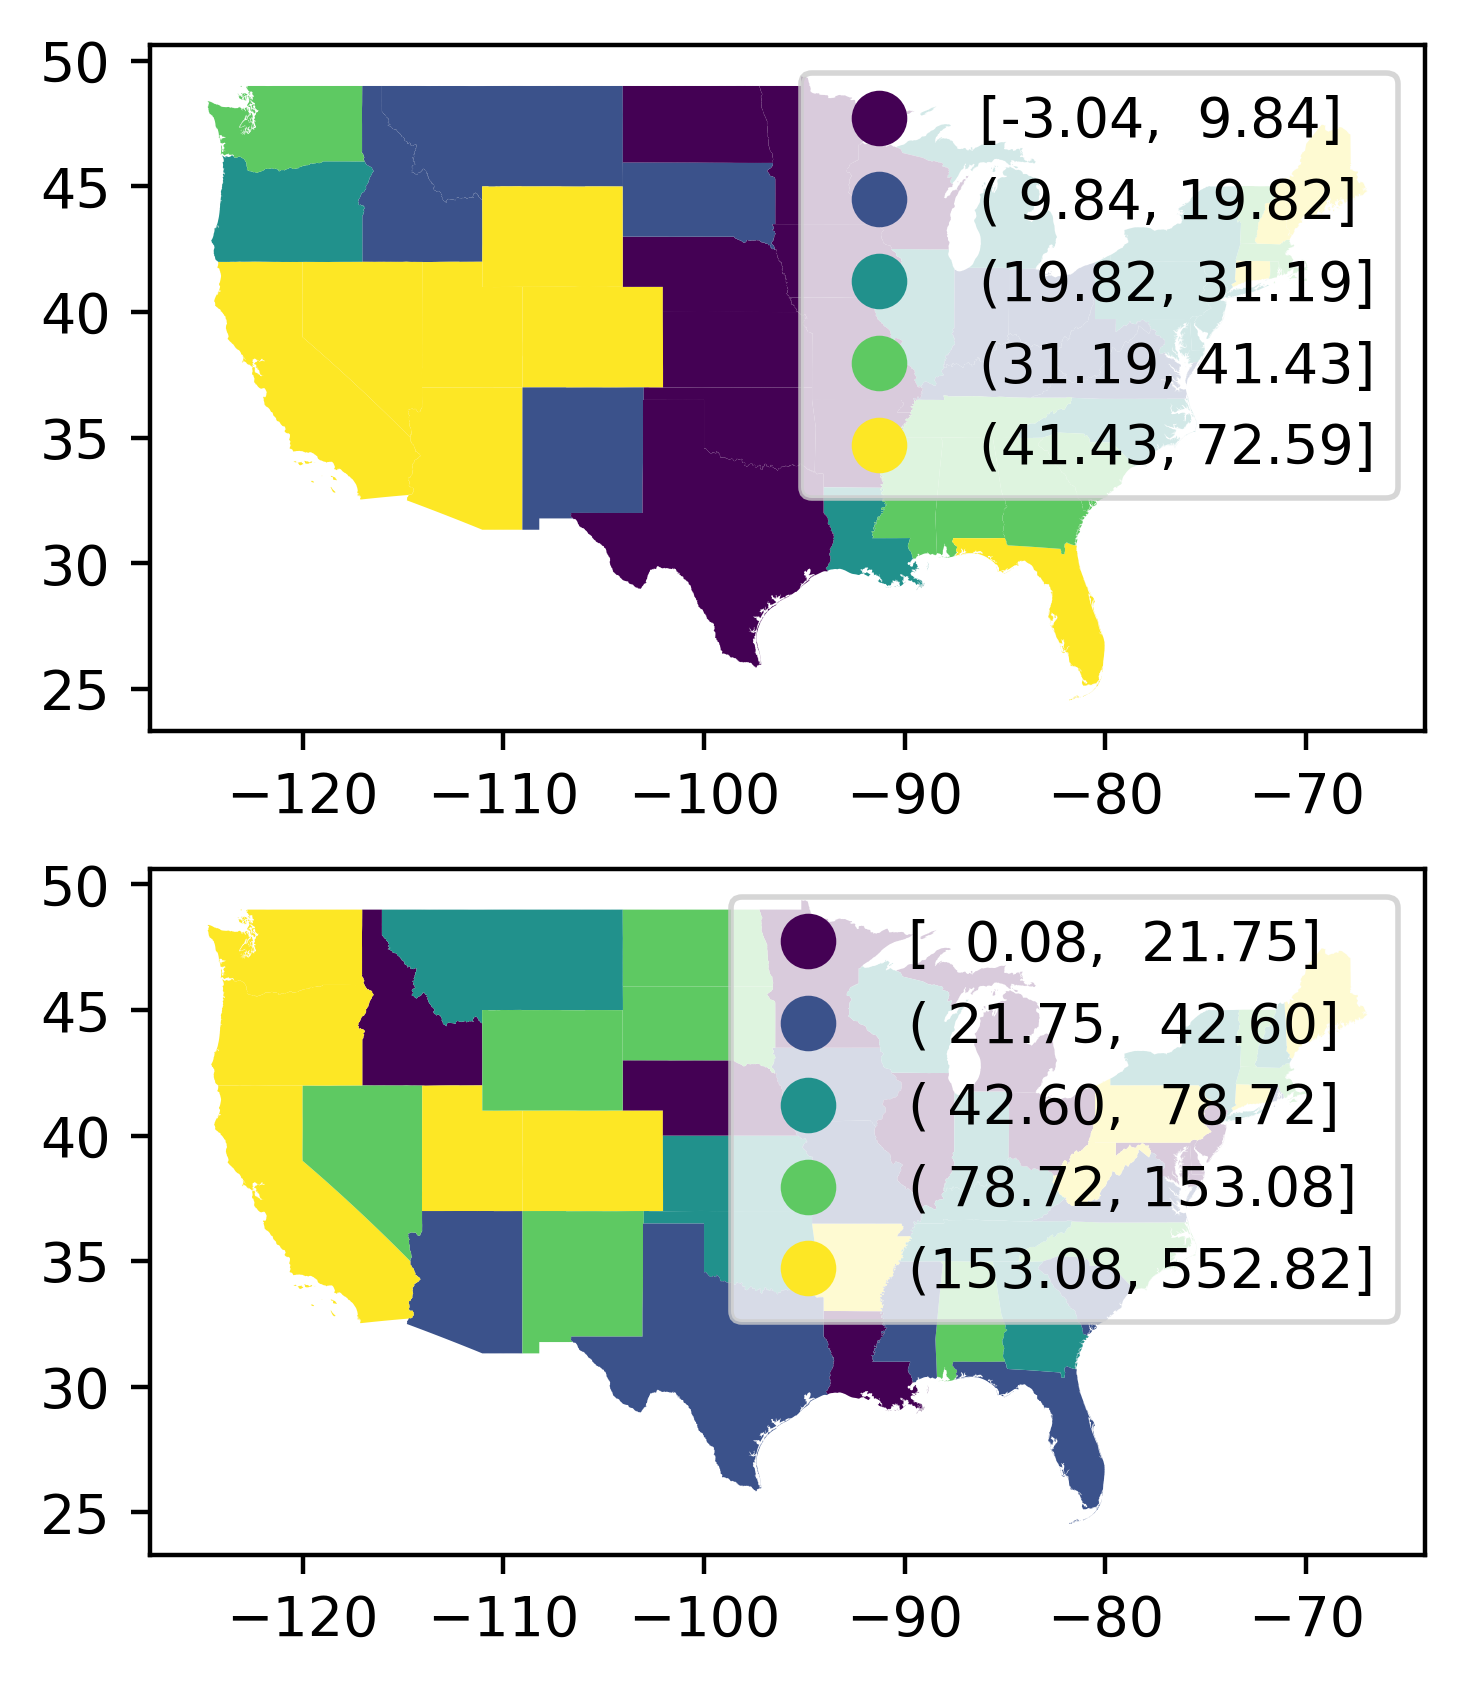

In [126]:
temp_df_check_rev_map = temp_df_check_revenues[['state', 'tech', 'revenue_change']].groupby(['tech','state'], as_index=False)['revenue_change'].mean()
temp_df_check_rev_map.head()
plot_file = map_file.merge(temp_df_check_rev_map, on=['state'])

fig, axs = plt.subplots(nrows=2, figsize=(9, 5), dpi=400)

axs_count = 0
for tech in ['pv','wind']:
    plot_data = plot_file.loc[(plot_file.tech == tech)]
#     print(plot_data.head())
    plot_data.plot(ax=axs[axs_count], column='revenue_change', legend=True, scheme='Quantiles')
#     ax.set_axis_off()
#     ax.set_title(f"Average Change in Generation - {tech}")
#     plt.axis('equal')
#     plt.show()
    axs_count += 1

In [128]:
temp_df_check_emissions_orig = df_orig[['state','scenario', 'batt_size', 'tech','lifetime_cambium_co2_rate_lrmer_mw']]
temp_df_check_emissions_new = df_new[['state','scenario', 'batt_size', 'tech','lifetime_cambium_co2_rate_lrmer_mw']]
temp_df_check_emissions = temp_df_check_emissions_orig.merge(temp_df_check_emissions_new,\
                                                 on = ['state','scenario', 'batt_size', 'tech'],\
                                                 suffixes=('_orig', '_new'))
temp_df_check_emissions['emissions_change'] = ((temp_df_check_emissions['lifetime_cambium_co2_rate_lrmer_mw_new'] - temp_df_check_emissions['lifetime_cambium_co2_rate_lrmer_mw_orig'])/(temp_df_check_emissions['lifetime_cambium_co2_rate_lrmer_mw_orig']))*100
temp_df_check_emissions.head()

state              scenario  batt_size  tech  \
0    TX   StdScen20_LowRECost      100.0    pv   
1    TX     StdScen20_MidCase      100.0    pv   
2    TX  StdScen20_HighRECost      100.0    pv   
3    AR   StdScen20_LowRECost      100.0  wind   
4    CA   StdScen20_LowRECost      100.0  wind   

   lifetime_cambium_co2_rate_lrmer_mw_orig  \
0                              9319.837224   
1                              9154.598935   
2                             11762.892953   
3                              1239.443375   
4                               786.081012   

   lifetime_cambium_co2_rate_lrmer_mw_new  emissions_change  
0                             2128.230524        -77.164510  
1                             1985.597238        -78.310385  
2                             2985.166108        -74.622177  
3                             9713.379361        683.688836  
4                             2517.208317        220.222506

In [129]:
temp_df_check_emissions.pivot(index=['state', 'scenario', 'batt_size'], columns='tech', values='emissions_change').reset_index()[['pv', 'wind']].quantile(q=[i/100 for i in range(101) if i % 5==0])

tech           pv        wind
0.00   -78.310385  -82.363953
0.05   -38.082167  -50.294398
0.10   -20.224802   -1.330124
0.15    -7.133440    2.184832
0.20    -1.691574    9.381544
0.25     1.807960   16.764994
0.30     4.914024   21.753128
0.35     7.154274   25.577054
0.40     9.692133   35.985238
0.45    11.367877   43.341442
0.50    14.095142   48.560876
0.55    16.515887   58.303308
0.60    19.132756   68.713621
0.65    20.860360   80.708530
0.70    26.432532   95.628548
0.75    30.097558  138.306911
0.80    36.500844  147.216128
0.85    51.627173  157.330147
0.90    70.848291  186.546588
0.95   136.846027  314.476462
1.00  2567.089040  683.688836

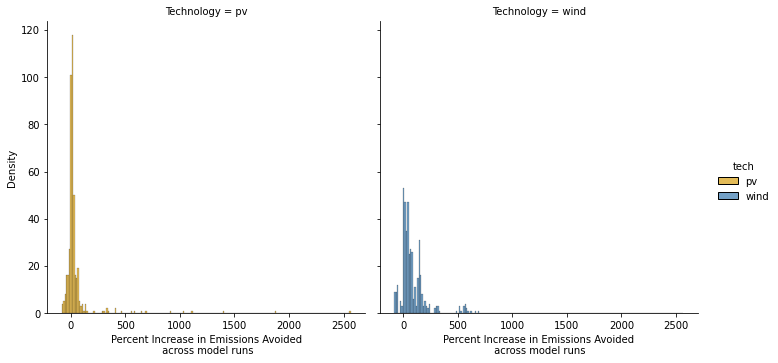

In [131]:
g = sns.displot(data=temp_df_check_emissions, x="emissions_change", hue="tech", col="tech", kind="hist",\
                palette = {"pv": "goldenrod", "wind": "steelblue"})
g.set_axis_labels("Percent Increase in Emissions Avoided\n across model runs","Density")
g.set_titles("Technology = {col_name}")

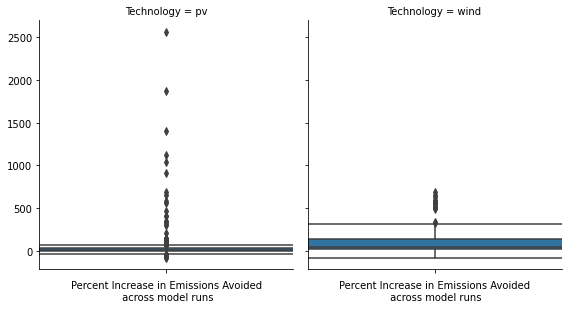

In [137]:
g = sns.catplot(y="emissions_change", hue="tech", col="tech",
                data=temp_df_check_emissions, kind="box",
#                 palette = {"pv": "goldenrod", "wind": "steelblue"},
                height=4, width=18)
g.set_axis_labels("Percent Increase in Emissions Avoided\n across model runs", "")
g.set_titles("Technology = {col_name}")

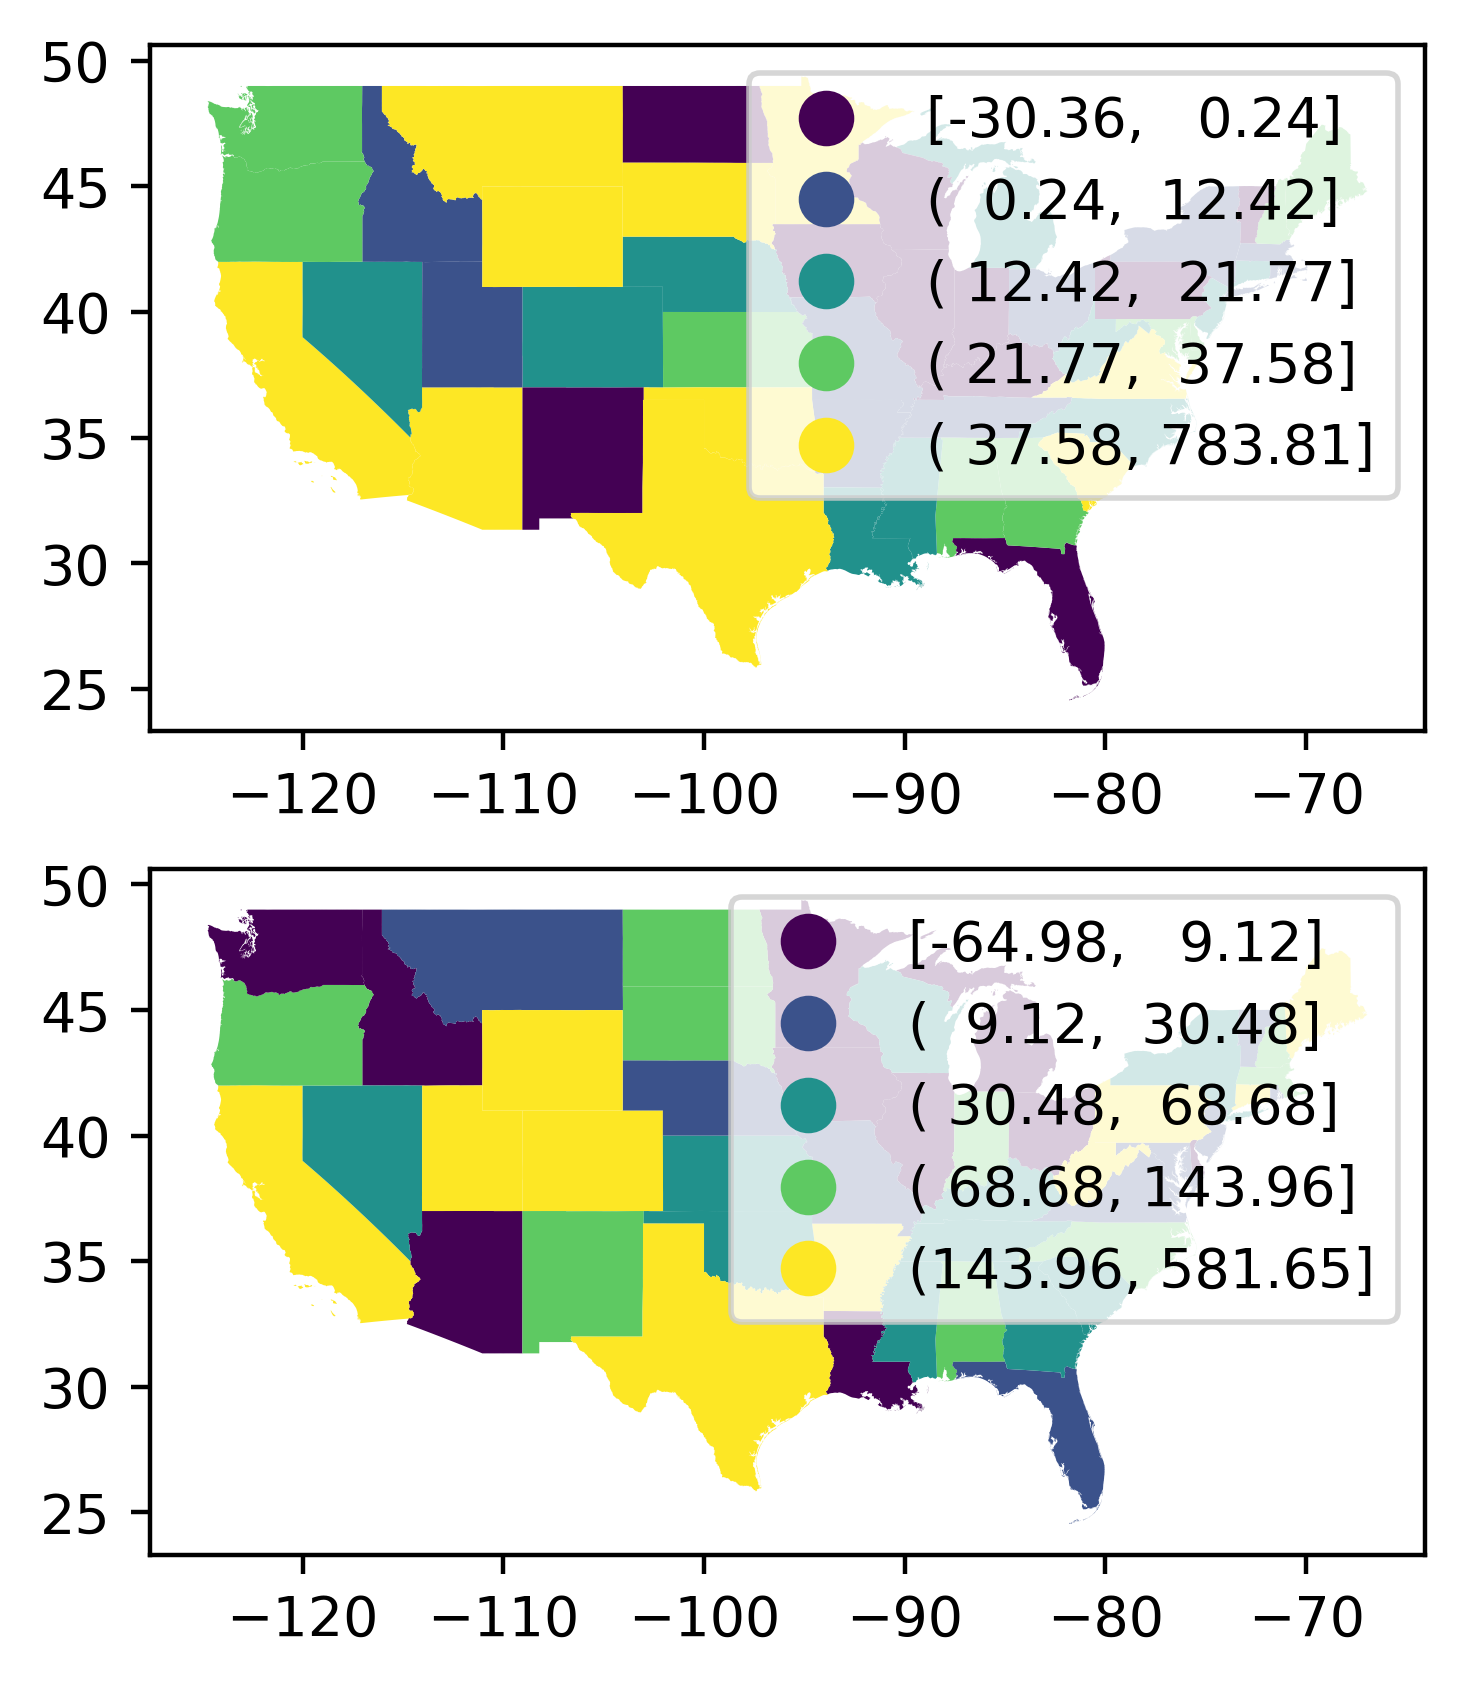

In [138]:
temp_df_check_emissions_map = temp_df_check_emissions[['state', 'tech', 'emissions_change']].groupby(['tech','state'], as_index=False)['emissions_change'].mean()
temp_df_check_emissions_map.head()
plot_file = map_file.merge(temp_df_check_emissions_map, on=['state'])

fig, axs = plt.subplots(nrows=2, figsize=(9, 5), dpi=400)

axs_count = 0
for tech in ['pv','wind']:
    plot_data = plot_file.loc[(plot_file.tech == tech)]
#     print(plot_data.head())
    plot_data.plot(ax=axs[axs_count], column='emissions_change', legend=True, scheme='Quantiles')
#     ax.set_axis_off()
#     ax.set_title(f"Average Change in Generation - {tech}")
#     plt.axis('equal')
#     plt.show()
    axs_count += 1

# Rerunning results - Regional

## state supply curves

Text(0.5, 1.0, 'ORIGINAL DATA')

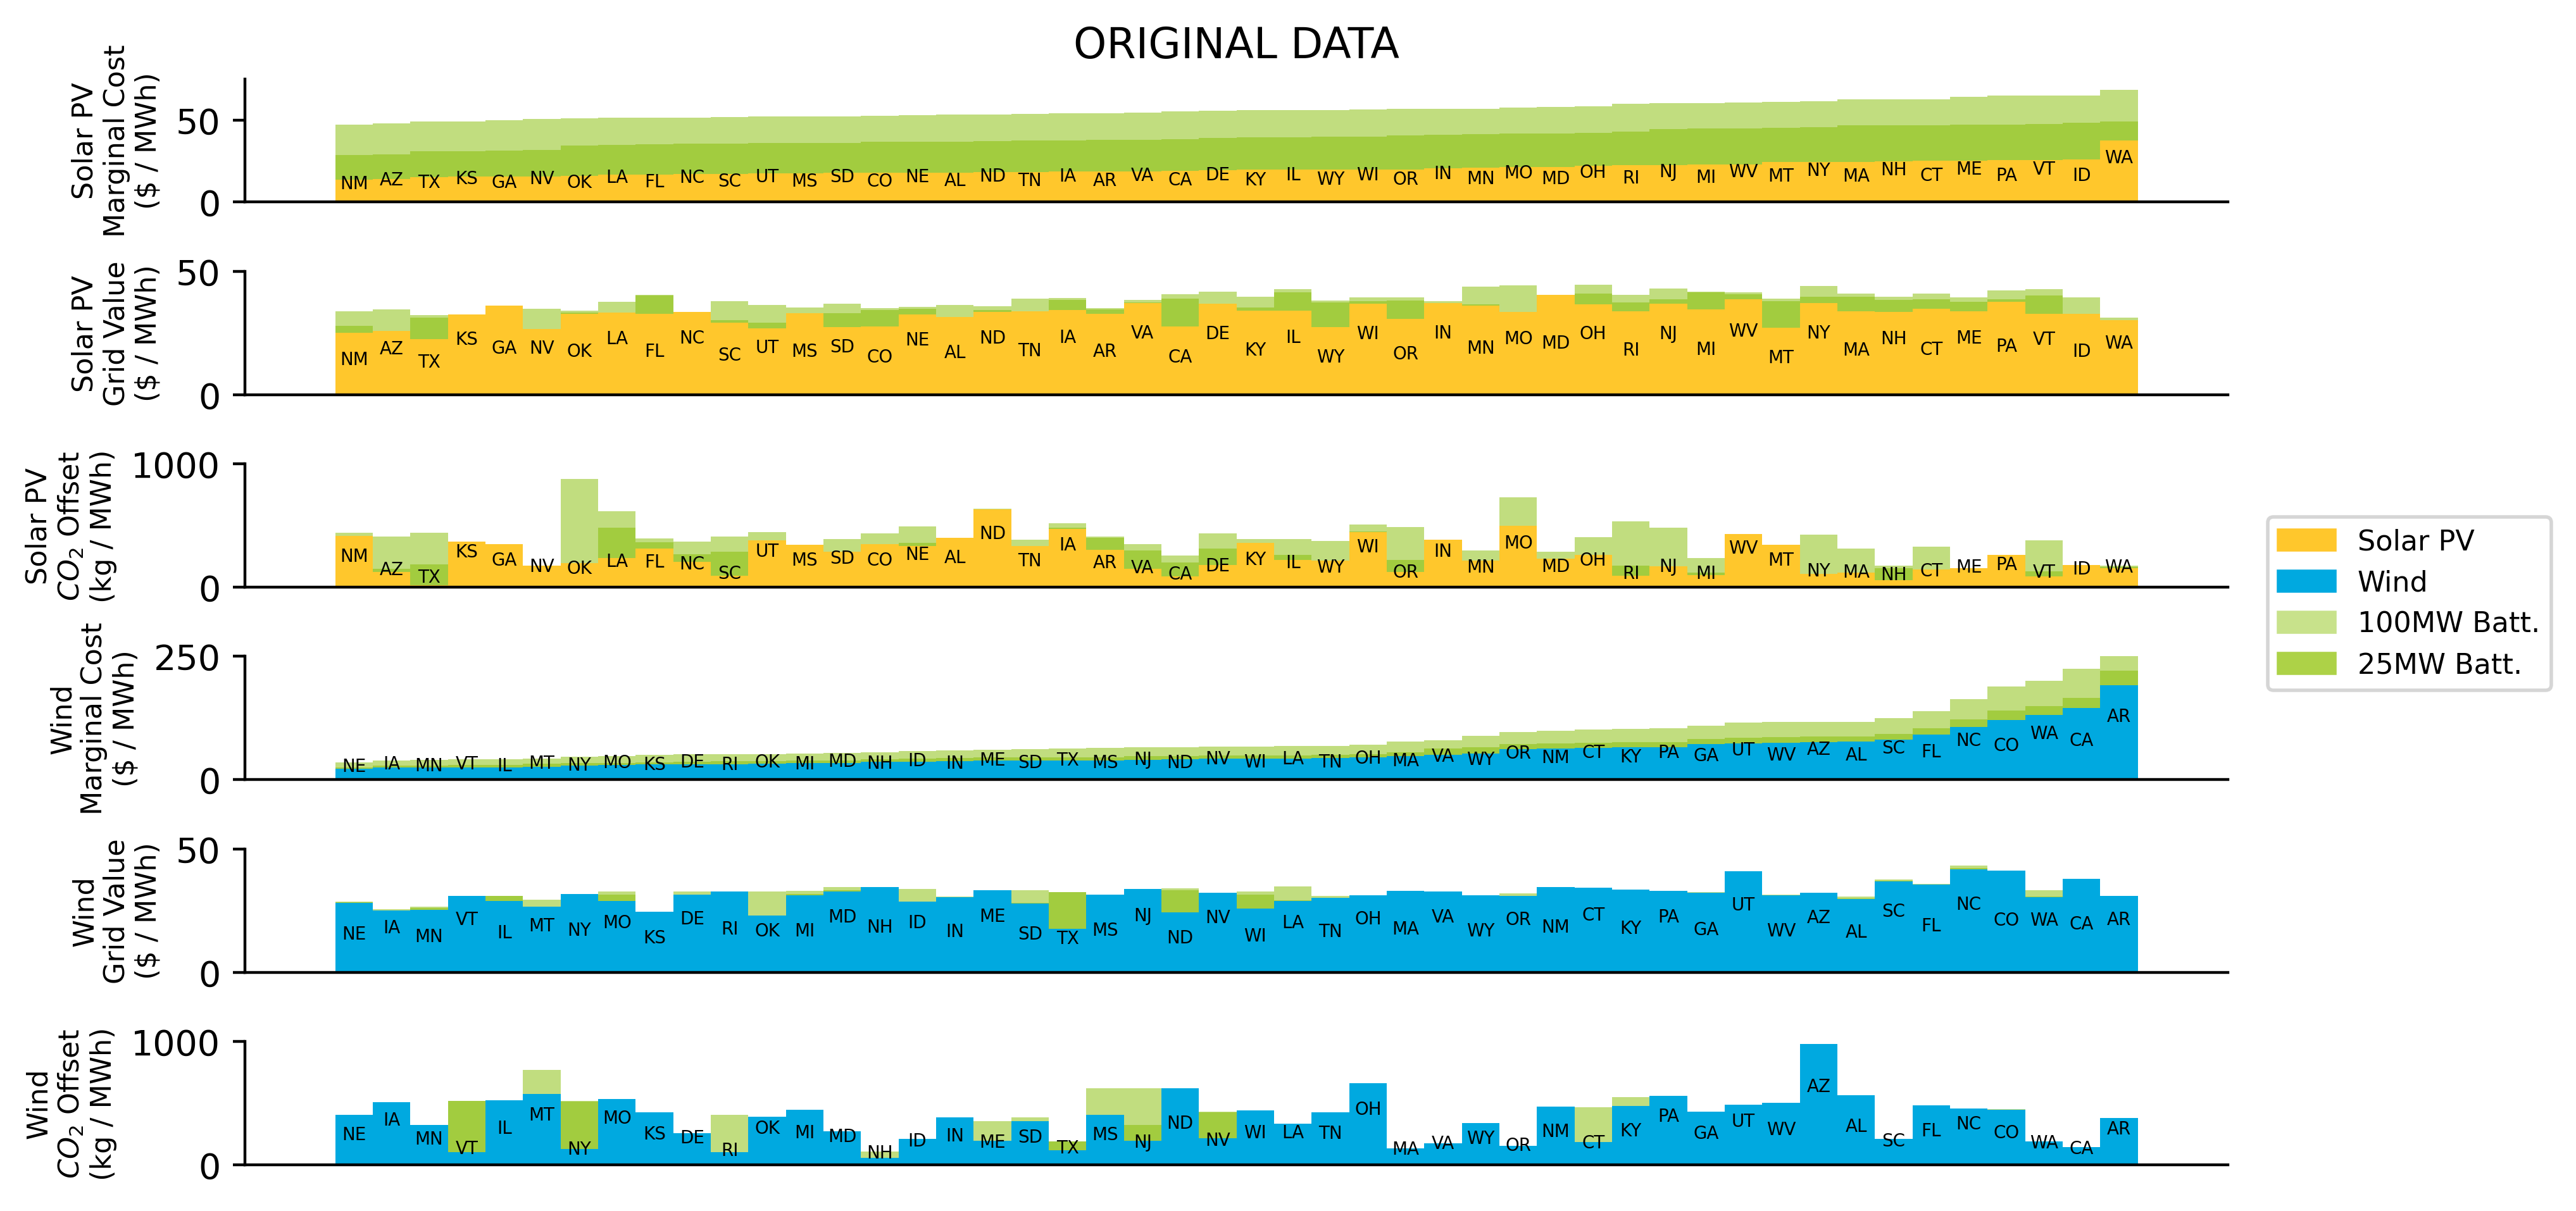

In [156]:
plot_df = df_orig.copy()
opt_var = opt_vars[0]
plot_vars = ['marginal_cost_mwh',
             'grid_value_per_mwh',
             'lifetime_cambium_co2_rate_lrmer_mwh']
sort_var = plot_vars[0]
ascending=True
batt_sizes=[25,100]

label_dict = {
    'marginal_cost_mwh':'Marginal Cost\n($ / MWh)',
    'grid_value_per_mwh':'Grid Value\n($ / MWh)',
    'lifetime_cambium_grid_value_mw':'Grid Value\n($ / MW)',
    'lifetime_cambium_co2_rate_avg_mw':'$CO_2 (\overline{x})$ Offset\n(kg / MW)',
    'lifetime_cambium_co2_rate_avg_mwh':'$CO_2 (\overline{x})$ Offset\n(kg / MWh)',
    'lifetime_cambium_co2_rate_lrmer_mw':'$CO_2$ Offset\n(kg / MW)',
    'lifetime_cambium_co2_rate_lrmer_mwh':'$CO_2$ Offset\n(kg / MWh)'
}

tech_label_dict = {'pv':'Solar PV', 'wind':'Wind', 'batt25':'25MW Batt.', 'batt100':'100MW Batt.'}

nrel_color_dict = [
                '#0077C8', #darkblue
                '#00A9E0', #lightblue
                '#658D1B', #darkgreen
                '#84BD00', #lightgreen
                '#FFC72C', #yellow
                '#DE7C00', #orange
                '#5B6770', #darkgray
                '#C1C6C8' #lightgray
                ]

tech_dict = {'pv':nrel_color_dict[4],
            'wind':nrel_color_dict[1],
            'batt100':'#c8e28b',
            'batt25':'#add247'}


fig, axs = plt.subplots(nrows=len(plot_vars)*2, figsize=(9, 5), dpi=400, sharex=True)

axs_count = 0
for tech in ['pv','wind']:
    for plot_var in plot_vars:
        
        # --- subset scenario ---
        no_batt = plot_df.loc[(plot_df['scenario'] == scenario) & (plot_df['batt_size'] == 0) & (plot_df['tech'] == tech)]

        # --- drop duplicate techs for same state ---
        no_batt.sort_values(opt_var, ascending=ascending, inplace=True)
        no_batt.drop_duplicates(subset=['state', 'scenario'], inplace=True, keep='first')
        no_batt.sort_values(sort_var, ascending=ascending, inplace=True)

        # --- mock up widths and bar positions and color ---
        width = [i for i in no_batt['system_capacity']]

        relative_positions = []
        relative_position = 0
        previous_width = 0
        for w in width:
            relative_position = float(relative_position + (previous_width/2) + (w/2))
            previous_width = w
            relative_positions.append(relative_position)

        colors = no_batt['tech'].map(tech_dict)

        axs[axs_count].bar(relative_positions, no_batt[plot_var],
                    width=width, linewidth=0.0,
                    color=colors)

        # --- mock up label positions ---
        odd = -1
        for i, l in enumerate(no_batt['state']):
            x = relative_positions[i]
            y_max = list(no_batt[plot_var])[i]
            y =  y_max / 2 + (odd * y_max * 0.075)
            axs[axs_count].annotate(l, xy=(x,y), ha='center',va='bottom',
                                    fontsize=5)
            odd *= -1

        # --- plot battery bars ---
        if batt_sizes != None:
            for batt_size in batt_sizes:
                batt = plot_df.loc[(plot_df['scenario'] == scenario) & (plot_df['batt_size'] == batt_size) & (plot_df['tech'] == tech)]
                batt.sort_values(opt_var, ascending=ascending, inplace=True)
                batt.drop_duplicates(subset=['state', 'scenario'], inplace=True, keep='first')
                batt.sort_values(sort_var, ascending=ascending, inplace=True)

                axs[axs_count].bar(relative_positions, batt[plot_var],
                        width=width, linewidth=0.0, alpha=0.5,
                        color=nrel_color_dict[3], zorder=0)

        # --- clean up ---
#         plt.title(f'{scen_label_dict[scenario]}', fontsize=10)
        plt.subplots_adjust(hspace=0.5)
        axs[axs_count].set_ylabel(f"{tech_label_dict[tech]}\n{label_dict[plot_var]}", 
                                  fontsize=8)#, 
                                  #ha='right',
                                  #rotation=0
                                 #)
        plt.xlabel('')#Cumulative RE Capacity')
        axs_count += 1
        
        
plt.tight_layout()
custom_patches = [mpatches.Patch(color=v, label=tech_label_dict[k]) for k,v in tech_dict.items()]
axs[2].legend(handles=custom_patches, bbox_to_anchor=(1.02, 0.57), loc=2, borderaxespad=0., fontsize=8)

sns.despine(fig)

axs[5].set_xticks([], [])

axs[0].set_ylim(0,75)
axs[1].set_ylim(0,50)
axs[2].set_ylim(0,1000)
axs[3].set_ylim(0,250)
axs[4].set_ylim(0,50)
axs[5].set_ylim(0,1000)
axs[0].set_title("ORIGINAL DATA")
    

Text(0.5, 1.0, 'NEW DATA')

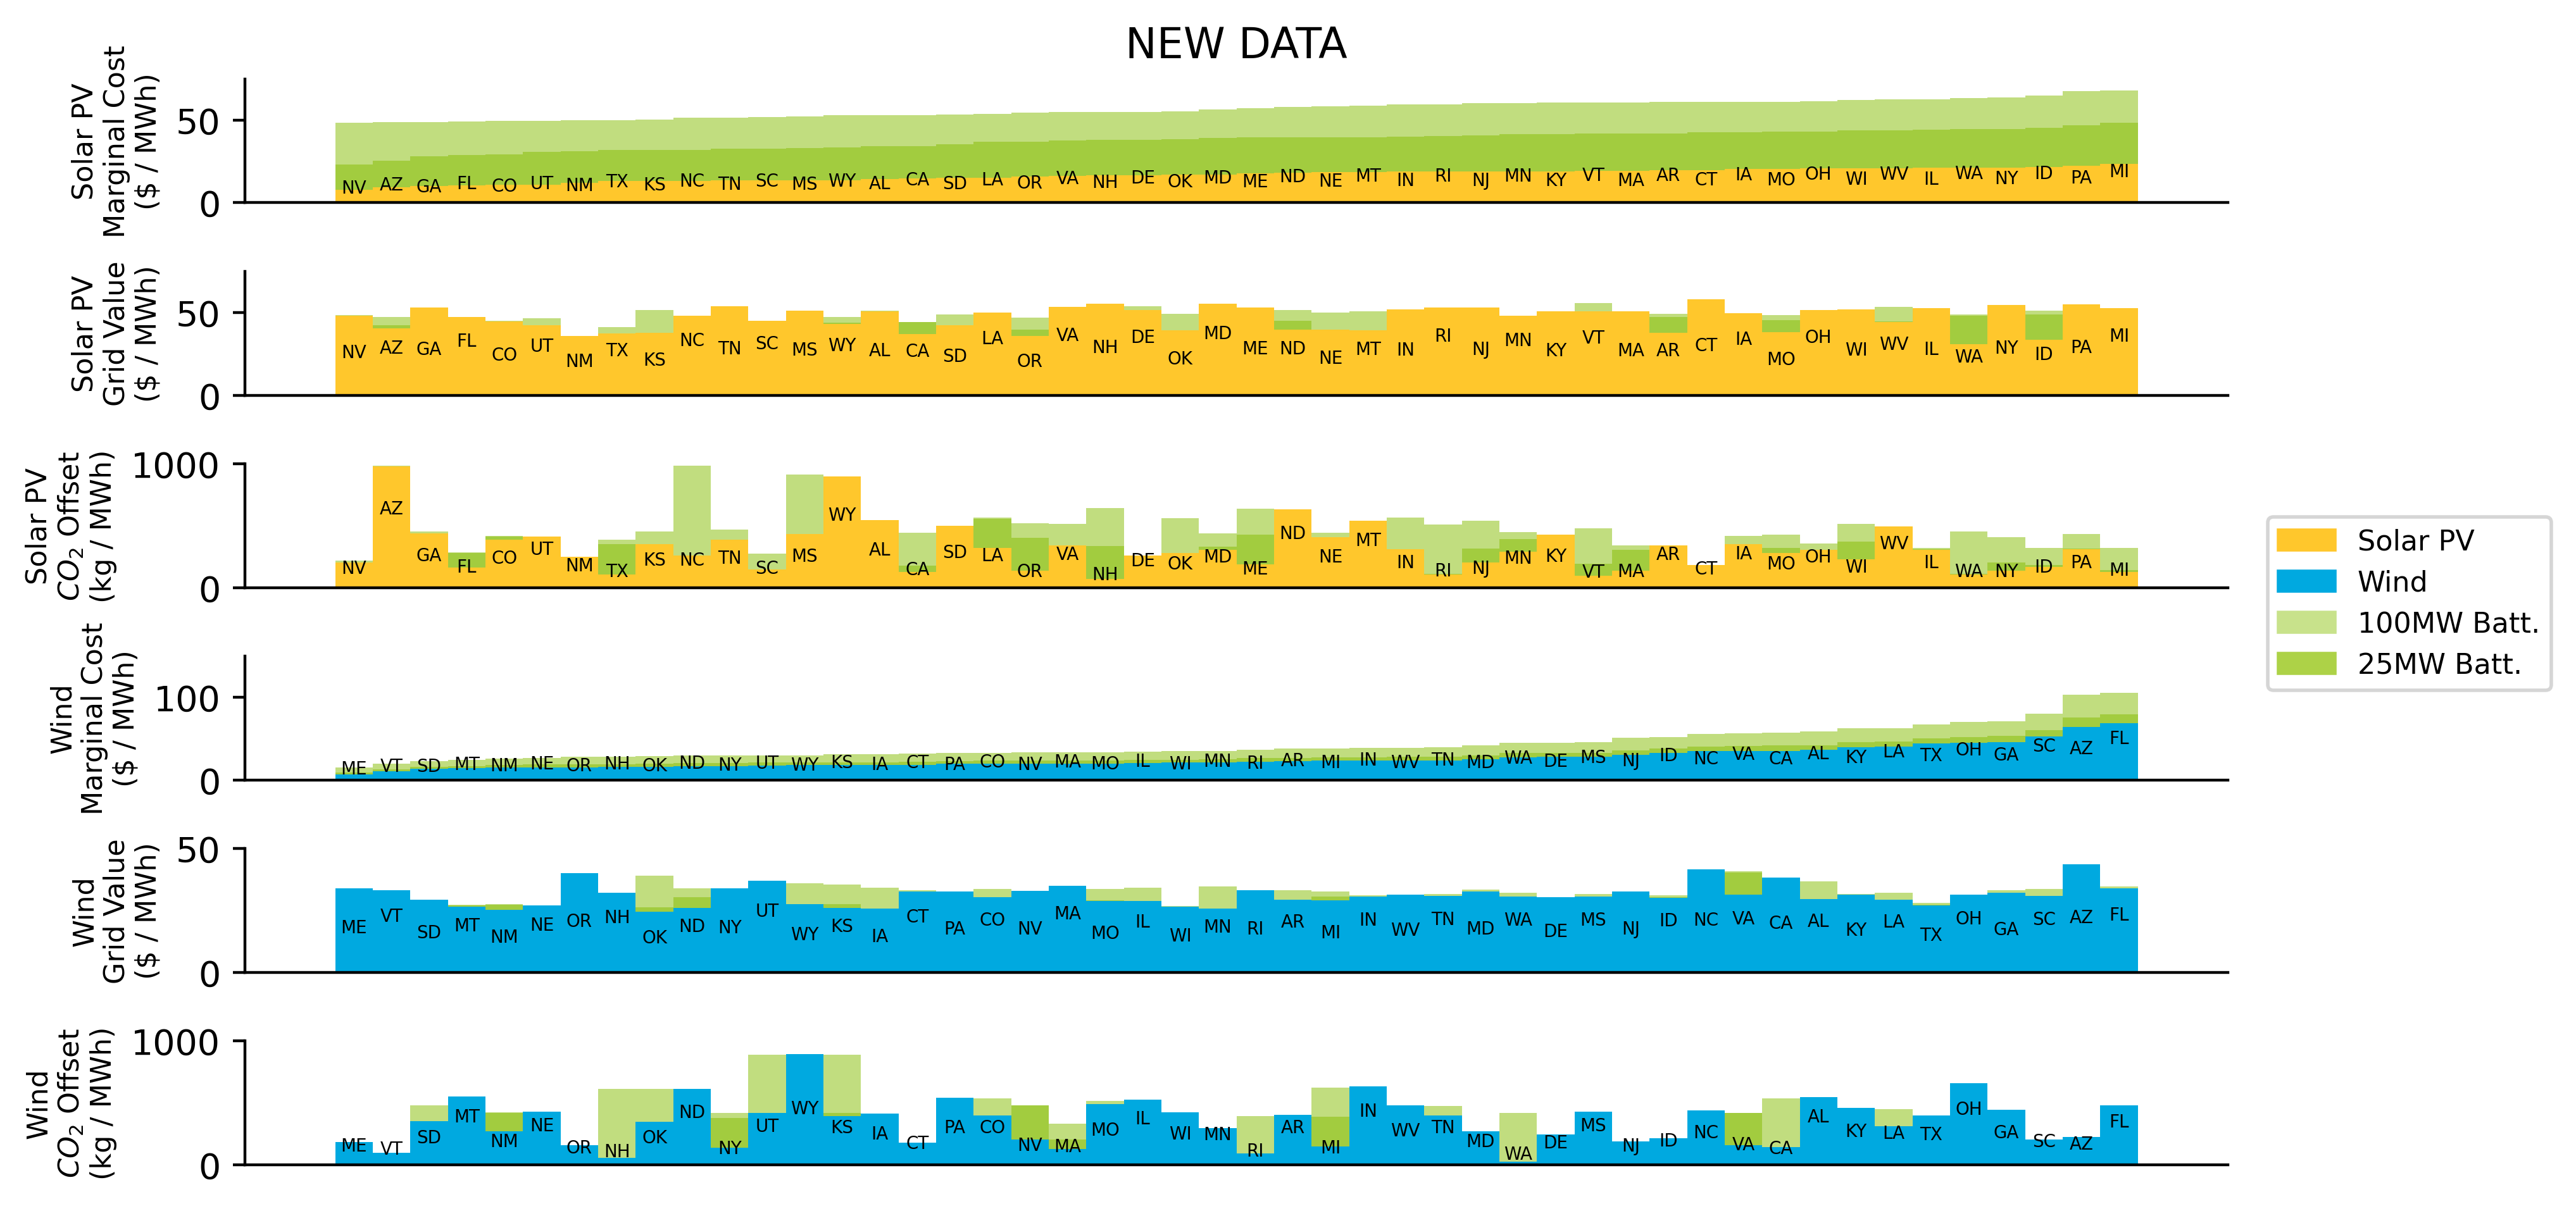

In [163]:
plot_df = df_new.copy()
opt_var = opt_vars[0]
plot_vars = ['marginal_cost_mwh',
             'grid_value_per_mwh',
             'lifetime_cambium_co2_rate_lrmer_mwh']
sort_var = plot_vars[0]
ascending=True
batt_sizes=[25,100]

label_dict = {
    'marginal_cost_mwh':'Marginal Cost\n($ / MWh)',
    'grid_value_per_mwh':'Grid Value\n($ / MWh)',
    'lifetime_cambium_grid_value_mw':'Grid Value\n($ / MW)',
    'lifetime_cambium_co2_rate_avg_mw':'$CO_2 (\overline{x})$ Offset\n(kg / MW)',
    'lifetime_cambium_co2_rate_avg_mwh':'$CO_2 (\overline{x})$ Offset\n(kg / MWh)',
    'lifetime_cambium_co2_rate_lrmer_mw':'$CO_2$ Offset\n(kg / MW)',
    'lifetime_cambium_co2_rate_lrmer_mwh':'$CO_2$ Offset\n(kg / MWh)'
}

tech_label_dict = {'pv':'Solar PV', 'wind':'Wind', 'batt25':'25MW Batt.', 'batt100':'100MW Batt.'}

nrel_color_dict = [
                '#0077C8', #darkblue
                '#00A9E0', #lightblue
                '#658D1B', #darkgreen
                '#84BD00', #lightgreen
                '#FFC72C', #yellow
                '#DE7C00', #orange
                '#5B6770', #darkgray
                '#C1C6C8' #lightgray
                ]

tech_dict = {'pv':nrel_color_dict[4],
            'wind':nrel_color_dict[1],
            'batt100':'#c8e28b',
            'batt25':'#add247'}


fig, axs = plt.subplots(nrows=len(plot_vars)*2, figsize=(9, 5), dpi=400, sharex=True)

axs_count = 0
for tech in ['pv','wind']:
    for plot_var in plot_vars:
        
        # --- subset scenario ---
        no_batt = plot_df.loc[(plot_df['scenario'] == scenario) & (plot_df['batt_size'] == 0) & (plot_df['tech'] == tech)]

        # --- drop duplicate techs for same state ---
        no_batt.sort_values(opt_var, ascending=ascending, inplace=True)
        no_batt.drop_duplicates(subset=['state', 'scenario'], inplace=True, keep='first')
        no_batt.sort_values(sort_var, ascending=ascending, inplace=True)

        # --- mock up widths and bar positions and color ---
        width = [i for i in no_batt['system_capacity']]

        relative_positions = []
        relative_position = 0
        previous_width = 0
        for w in width:
            relative_position = float(relative_position + (previous_width/2) + (w/2))
            previous_width = w
            relative_positions.append(relative_position)

        colors = no_batt['tech'].map(tech_dict)

        axs[axs_count].bar(relative_positions, no_batt[plot_var],
                    width=width, linewidth=0.0,
                    color=colors)

        # --- mock up label positions ---
        odd = -1
        for i, l in enumerate(no_batt['state']):
            x = relative_positions[i]
            y_max = list(no_batt[plot_var])[i]
            y =  y_max / 2 + (odd * y_max * 0.075)
            axs[axs_count].annotate(l, xy=(x,y), ha='center',va='bottom',
                                    fontsize=5)
            odd *= -1

        # --- plot battery bars ---
        if batt_sizes != None:
            for batt_size in batt_sizes:
                batt = plot_df.loc[(plot_df['scenario'] == scenario) & (plot_df['batt_size'] == batt_size) & (plot_df['tech'] == tech)]
                batt.sort_values(opt_var, ascending=ascending, inplace=True)
                batt.drop_duplicates(subset=['state', 'scenario'], inplace=True, keep='first')
                batt.sort_values(sort_var, ascending=ascending, inplace=True)

                axs[axs_count].bar(relative_positions, batt[plot_var],
                        width=width, linewidth=0.0, alpha=0.5,
                        color=nrel_color_dict[3], zorder=0)

        # --- clean up ---
#         plt.title(f'{scen_label_dict[scenario]}', fontsize=10)
        plt.subplots_adjust(hspace=0.5)
        axs[axs_count].set_ylabel(f"{tech_label_dict[tech]}\n{label_dict[plot_var]}", 
                                  fontsize=8)#, 
                                  #ha='right',
                                  #rotation=0
                                 #)
        plt.xlabel('')#Cumulative RE Capacity')
        axs_count += 1
        
        
plt.tight_layout()
custom_patches = [mpatches.Patch(color=v, label=tech_label_dict[k]) for k,v in tech_dict.items()]
axs[2].legend(handles=custom_patches, bbox_to_anchor=(1.02, 0.57), loc=2, borderaxespad=0., fontsize=8)

sns.despine(fig)

axs[5].set_xticks([], [])

axs[0].set_ylim(0,75)
axs[1].set_ylim(0,75)
axs[2].set_ylim(0,1000)
axs[3].set_ylim(0,150)
axs[4].set_ylim(0,50)
axs[5].set_ylim(0,1000)
axs[0].set_title("NEW DATA")

## Chloropleths

In [165]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)
# df.drop_duplicates(['scenario','state','tech','batt_size'], inplace=True) #keep best performing system by region/scenario

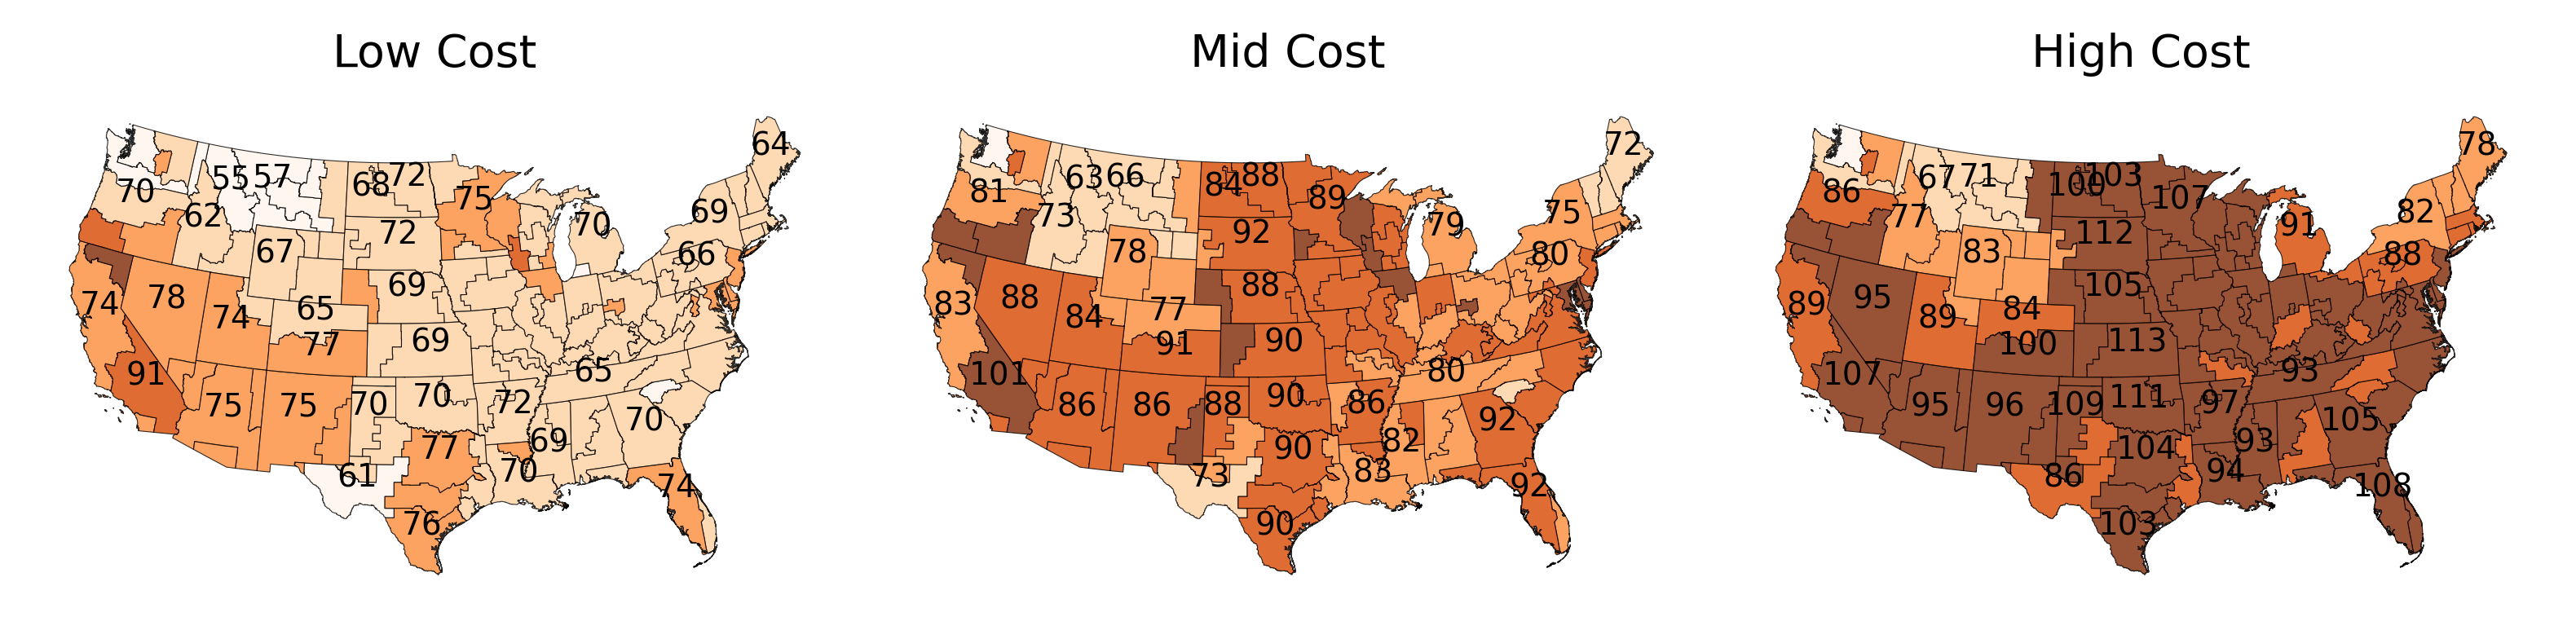

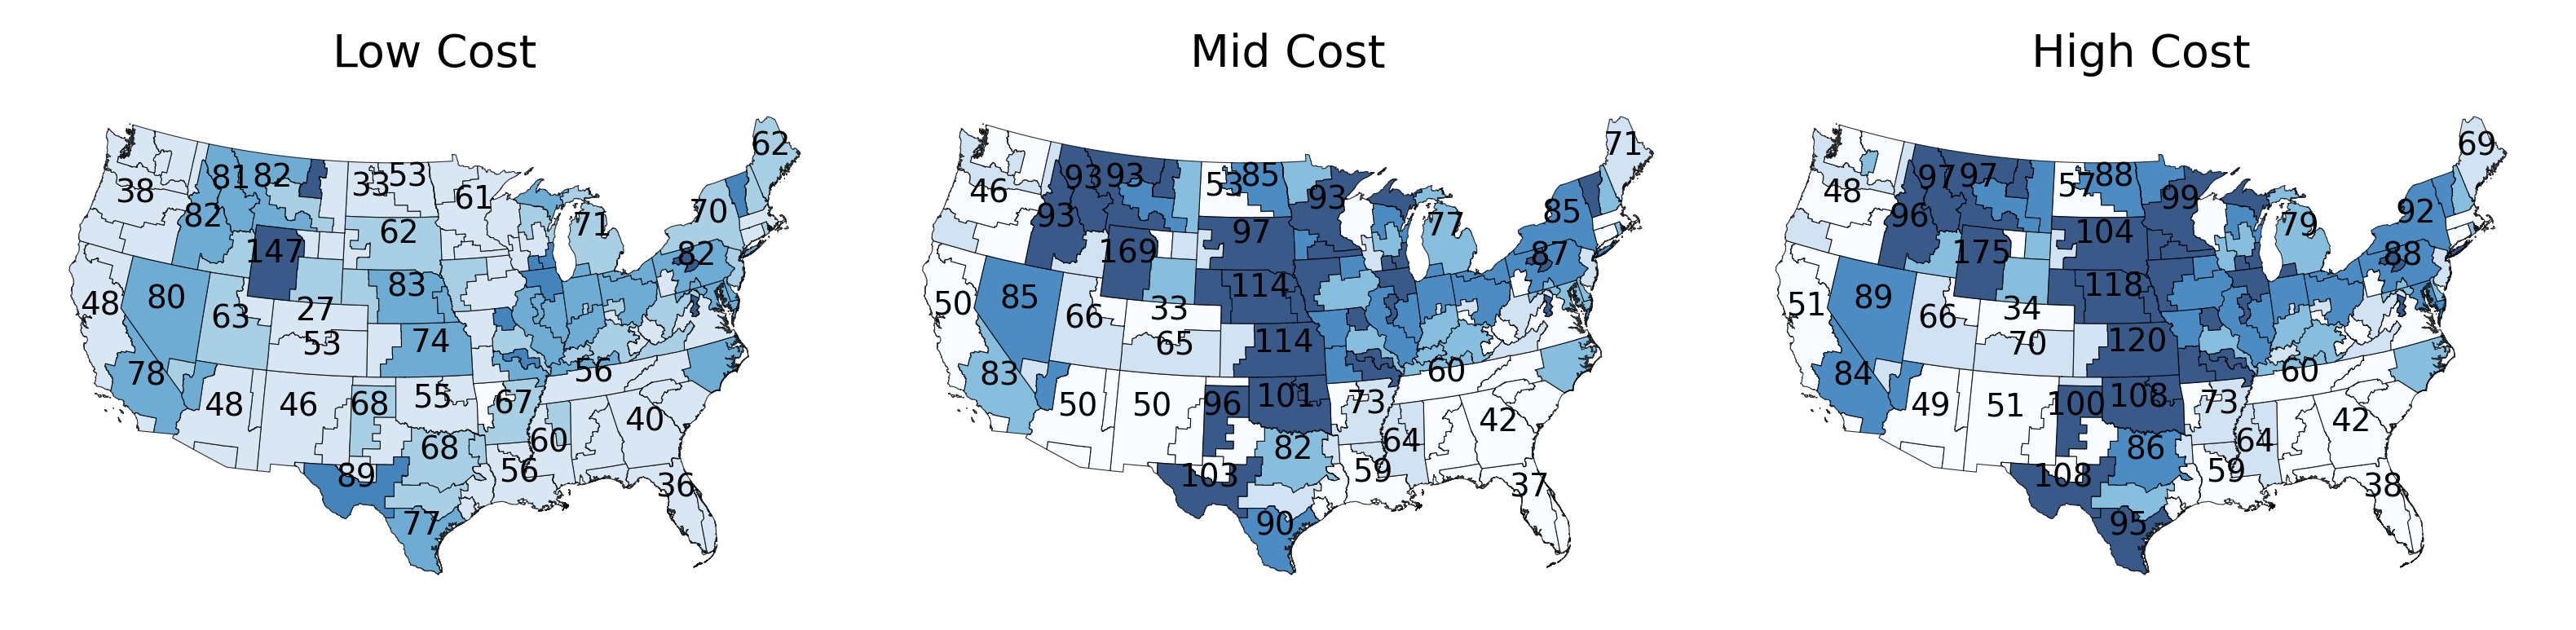

In [166]:
# --- Create Viz object ---
Viz = vapor.Visualizer(results=df, aggregate_region=aggregate_region, region_label_pct=0.75)
plot_df = Viz.gdf

Viz.triple_choropleth(column='lifetime_cambium_grid_value',
               tech='pv',
               ascending=True, reverse_cmap=False)

Viz.triple_choropleth(column='lifetime_cambium_grid_value',
               tech='wind',
               ascending=True, reverse_cmap=False)

In [167]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results', 'best_by_region',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)
# df.drop_duplicates(['scenario','state','tech','batt_size'], inplace=True) #keep best performing system by region/scenario

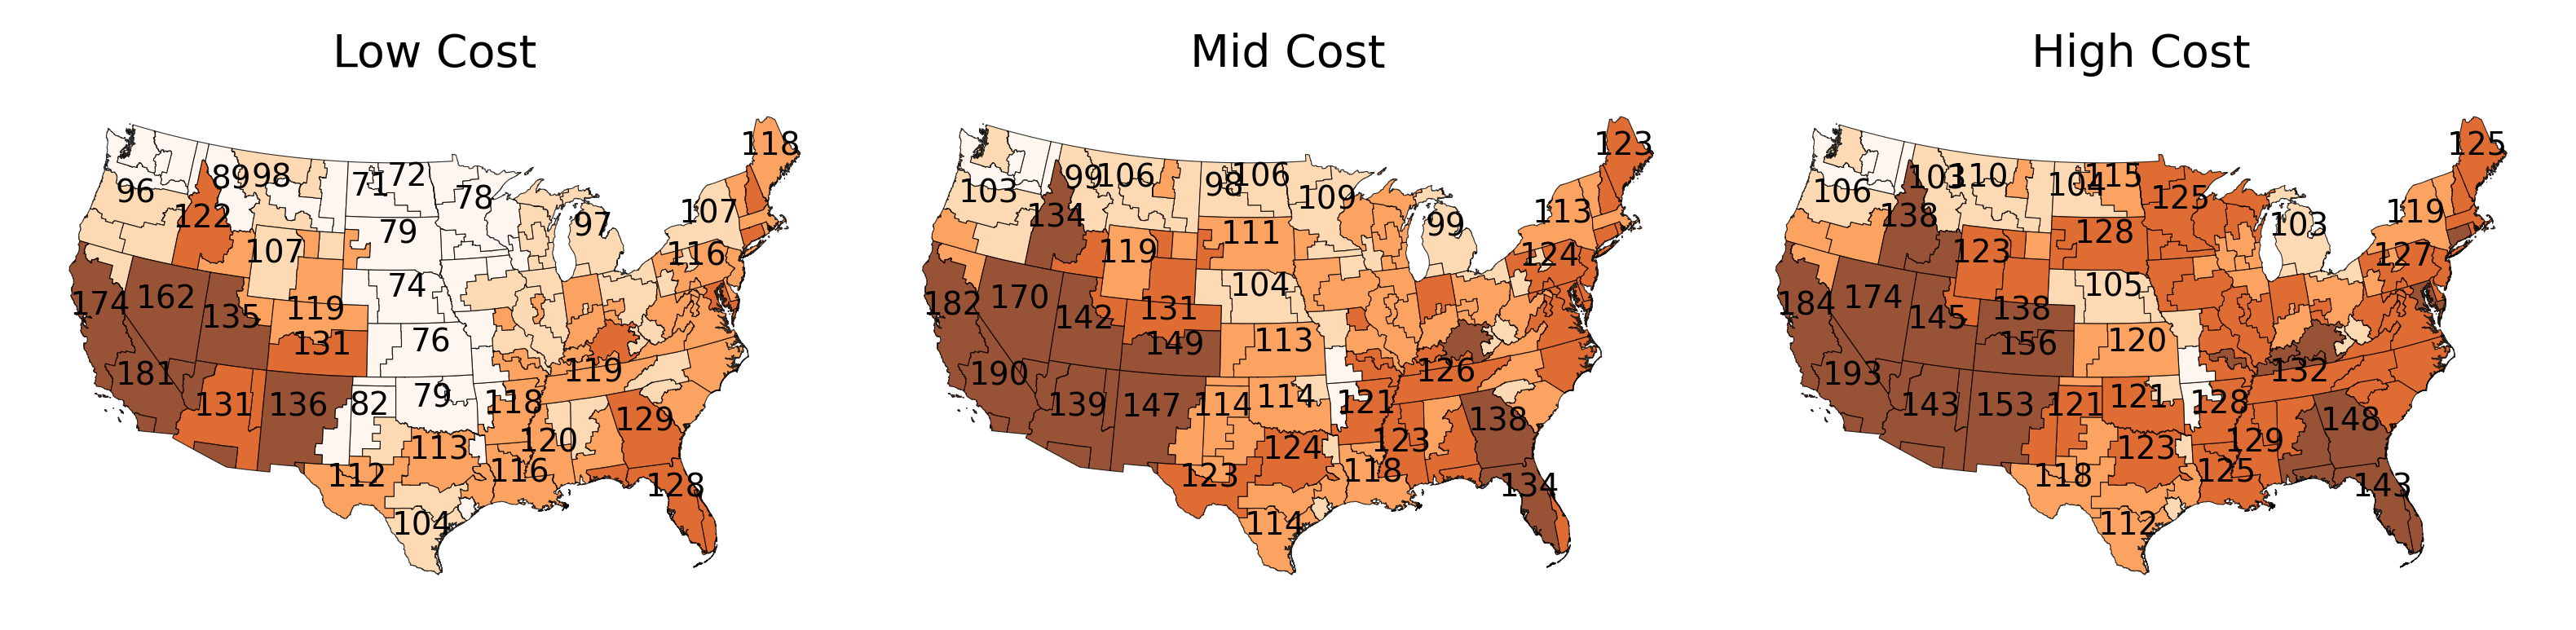

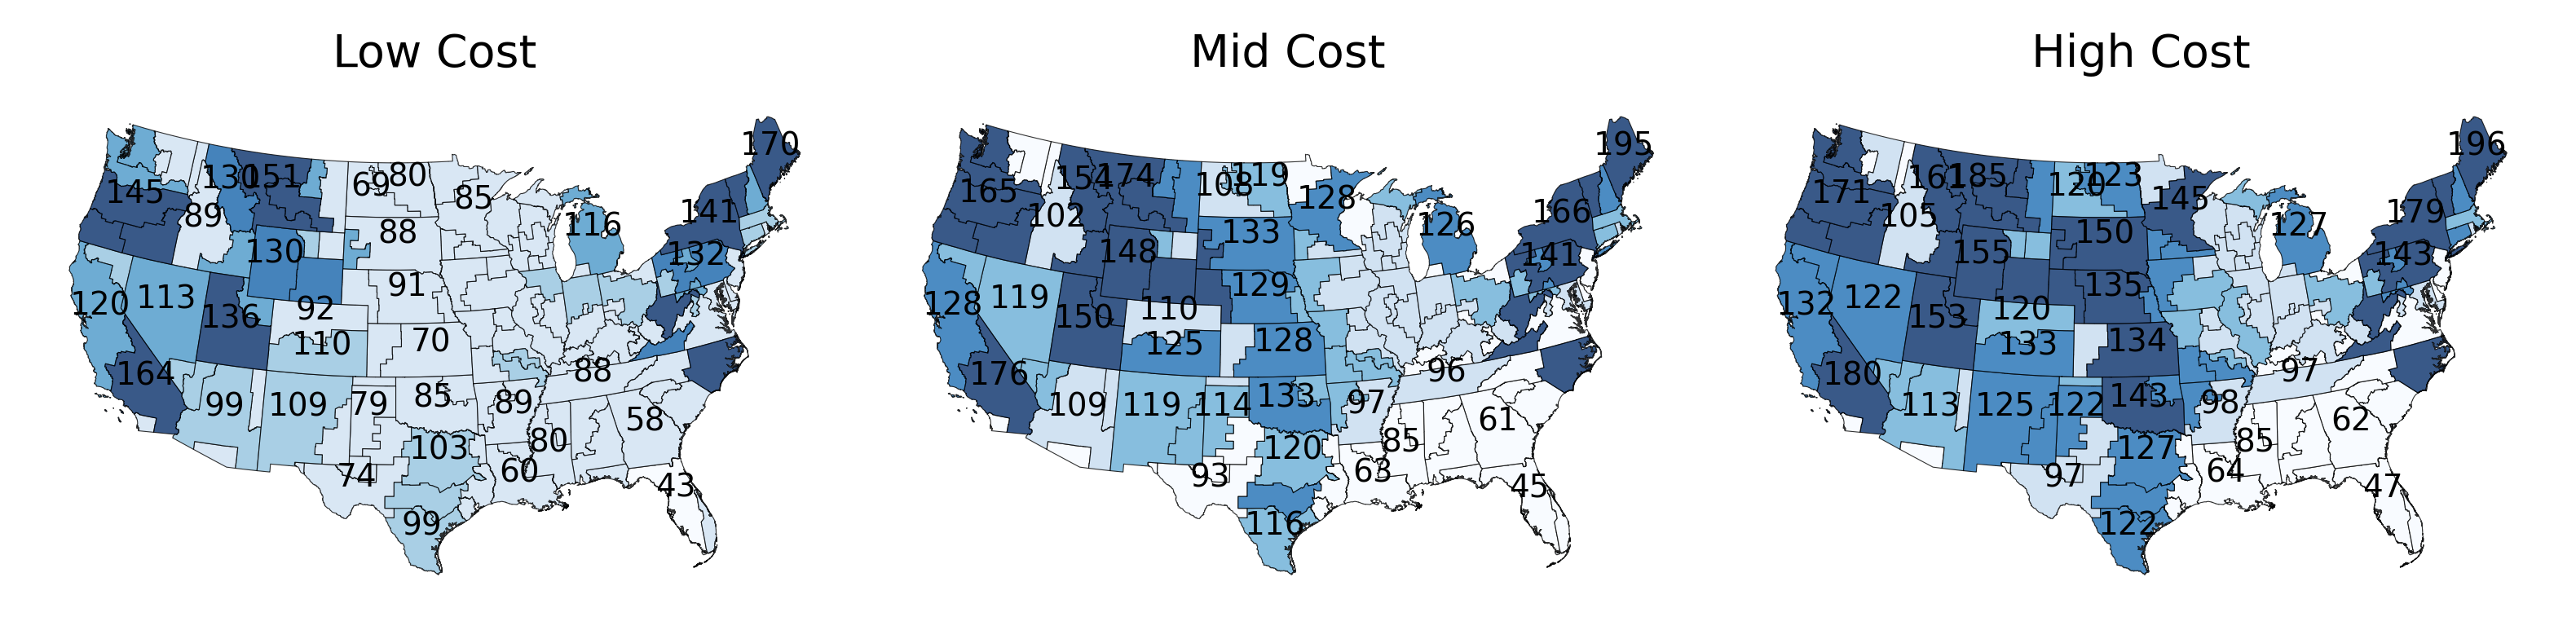

In [168]:
# --- Create Viz object ---
Viz = vapor.Visualizer(results=df, aggregate_region=aggregate_region, region_label_pct=0.75)
plot_df = Viz.gdf

Viz.triple_choropleth(column='lifetime_cambium_grid_value',
               tech='pv',
               ascending=True, reverse_cmap=False)

Viz.triple_choropleth(column='lifetime_cambium_grid_value',
               tech='wind',
               ascending=True, reverse_cmap=False)

### Table 2 - Average Values for Tech and Scenario Results

In [256]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

grouped_orig = results.groupby(['scenario','tech','batt_size'], as_index=False)\
                [['grid_value_per_mwh',
                  'marginal_cost_mwh',
                  'lifetime_cambium_co2_rate_avg_mwh',
                  'lifetime_cambium_co2_rate_lrmer_mwh']].mean()

rename_dict = {'StdScen20_HighRECost':'High Cost', 'StdScen20_MidCase':'Mid Cost', 'StdScen20_LowRECost':'Low Cost'}

grouped_orig['scenario'] = grouped_orig['scenario'].map(rename_dict)
grouped_orig['scenario'] = pd.Categorical(grouped_orig['scenario'], categories=['Low Cost', 'Mid Cost', 'High Cost'], ordered=True)

tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped_orig['tech'] = grouped_orig['tech'].map(tech_dict)

grouped_orig.sort_values(['scenario','tech','batt_size'], inplace=True)

x_1 = grouped_orig.groupby(['scenario', 'tech'], as_index=False)[['grid_value_per_mwh', 'marginal_cost_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(1)*100).round(decimals=1))
x_2 = grouped_orig.groupby(['scenario', 'tech'], as_index=False)[['grid_value_per_mwh', 'marginal_cost_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(2)*100).round(decimals=1))

x_3 = x_1.merge(x_2, left_index=True, right_index=True, suffixes=('_1', '_2'))
x_3 = pd.concat([x_1.loc[x_3.isnull().apply(sum, axis=1) > 0], x_2.loc[x_3.isnull().apply(sum, axis=1) == 0]]).sort_index()
x_3.columns = ['grid_value_per_mwh_change', 'marginal_cost_mwh_change', 'lifetime_cambium_co2_rate_lrmer_mwh_change']

grouped_orig = grouped_orig.merge(x_3, left_index=True, right_index=True)
grouped_orig = grouped_orig[['scenario', 'tech', 'batt_size', 'grid_value_per_mwh', 'grid_value_per_mwh_change',\
         'marginal_cost_mwh', 'marginal_cost_mwh_change',  'lifetime_cambium_co2_rate_lrmer_mwh',\
         'lifetime_cambium_co2_rate_lrmer_mwh_change']]

grouped= grouped_orig.rename(columns = {'scenario':'Scenario',
                          'tech':'Tech',
                          'batt_size':'Batt Size (MW)', 
                          'grid_value_per_mwh': 'Grid Value ($ / MWh)', 
                          'lifetime_cambium_co2_rate_avg_mwh': 'Average Avoided CO2 (lbs / MWh)',
                         'lifetime_cambium_co2_rate_lrmer_mwh': 'LRMER Avoided CO2 (lbs / MWh)',
                         'marginal_cost_mwh': "Marginal Cost ($/MWh)",
                         'grid_value_per_mwh_change': "Change",
                          'marginal_cost_mwh_change': "Change",
                          'lifetime_cambium_co2_rate_lrmer_mwh_change': "Change",
                         })

grouped

Scenario  Tech  Batt Size (MW)  Grid Value ($ / MWh)  Change  \
6    Low Cost    PV             0.0             27.714195     NaN   
7    Low Cost    PV            25.0             30.820472    11.2   
8    Low Cost    PV           100.0             32.555585    17.5   
9    Low Cost  Wind             0.0             26.374207     NaN   
10   Low Cost  Wind            25.0             26.032054    -1.3   
11   Low Cost  Wind           100.0             26.622324     0.9   
12   Mid Cost    PV             0.0             33.283766     NaN   
13   Mid Cost    PV            25.0             36.069624     8.4   
14   Mid Cost    PV           100.0             37.517386    12.7   
15   Mid Cost  Wind             0.0             30.543849     NaN   
16   Mid Cost  Wind            25.0             30.390062    -0.5   
17   Mid Cost  Wind           100.0             31.054158     1.7   
0   High Cost    PV             0.0             38.164606     NaN   
1   High Cost    PV            25.0             40.279885     5.5   
2   High Cost    PV           100.0             40.870225     7.1   
3   High Cost  Wind             0.0             31.229321     NaN   
4   High Cost  Wind            25.0             31.345425     0.4   
5   High Cost  Wind           100.0             32.133603     2.9   

    Marginal Cost ($/MWh)  Change  LRMER Avoided CO2 (lbs / MWh)  Change  
6               20.364619     NaN                     210.212906     NaN  
7               39.717529    95.0                     218.882709     4.1  
8               55.357104   171.8                     246.345462    17.2  
9               42.582606     NaN                     278.100673     NaN  
10              49.156747    15.4                     272.250730    -2.1  
11              66.670415    56.6                     269.823035    -3.0  
12              18.939654     NaN                     290.056015     NaN  
13              38.402482   102.8                     299.306336     3.2  
14              54.217785   186.3                     329.886522    13.7  
15              41.406993     NaN                     369.523144     NaN  
16              47.973824    15.9                     363.061930    -1.7  
17              65.287326    57.7                     360.417470    -2.5  
0               17.729202     NaN                     355.296804     NaN  
1               37.272478   110.2                     362.480717     2.0  
2               53.396732   201.2                     385.634282     8.5  
3               41.267100     NaN                     419.086236     NaN  
4               47.705449    15.6                     414.264457    -1.2  
5               64.932864    57.3                     412.559781    -1.6

In [255]:
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['project_return_aftertax_npv']#['marginal_cost_mwh']
scenarios = ['StdScen20_HighRECost', 'StdScen20_LowRECost', 'StdScen20_MidCase']
techs = ['pv', 'wind']
batt_sizes = [0., 25., 100.]
batt_durations = [4.]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for batt_size in batt_sizes:
                for batt_duration in batt_durations:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_batt_{batt_size}_{batt_duration}.pkl"
                    fp = os.path.join('results', 'best_by_region',file)
                    dfs.append(pd.read_pickle(fp))


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

grouped_new = results.groupby(['scenario','tech','batt_size'], as_index=False)\
                [['grid_value_per_mwh',
                  'marginal_cost_mwh',
                  'lifetime_cambium_co2_rate_avg_mwh',
                  'lifetime_cambium_co2_rate_lrmer_mwh']].mean()

rename_dict = {'StdScen20_HighRECost':'High Cost', 'StdScen20_MidCase':'Mid Cost', 'StdScen20_LowRECost':'Low Cost'}

grouped_new['scenario'] = grouped_new['scenario'].map(rename_dict)
grouped_new['scenario'] = pd.Categorical(grouped_new['scenario'], categories=['Low Cost', 'Mid Cost', 'High Cost'], ordered=True)

tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped_new['tech'] = grouped_new['tech'].map(tech_dict)

grouped_new.sort_values(['scenario','tech','batt_size'], inplace=True)

x_1 = grouped_new.groupby(['scenario', 'tech'], as_index=False)[['grid_value_per_mwh', 'marginal_cost_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(1)*100).round(decimals=1))
x_2 = grouped_new.groupby(['scenario', 'tech'], as_index=False)[['grid_value_per_mwh', 'marginal_cost_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(2)*100).round(decimals=1))

x_3 = x_1.merge(x_2, left_index=True, right_index=True, suffixes=('_1', '_2'))
x_3 = pd.concat([x_1.loc[x_3.isnull().apply(sum, axis=1) > 0], x_2.loc[x_3.isnull().apply(sum, axis=1) == 0]]).sort_index()
x_3.columns = ['grid_value_per_mwh_change', 'marginal_cost_mwh_change', 'lifetime_cambium_co2_rate_lrmer_mwh_change']

grouped_new = grouped_new.merge(x_3, left_index=True, right_index=True)
grouped_new = grouped_new[['scenario', 'tech', 'batt_size', 'grid_value_per_mwh', 'grid_value_per_mwh_change',\
         'marginal_cost_mwh', 'marginal_cost_mwh_change',  'lifetime_cambium_co2_rate_lrmer_mwh',\
         'lifetime_cambium_co2_rate_lrmer_mwh_change']]

grouped = grouped_new.rename(columns = {'scenario':'Scenario',
                          'tech':'Tech',
                          'batt_size':'Batt Size (MW)', 
                          'grid_value_per_mwh': 'Grid Value ($ / MWh)', 
                          'lifetime_cambium_co2_rate_avg_mwh': 'Average Avoided CO2 (lbs / MWh)',
                         'lifetime_cambium_co2_rate_lrmer_mwh': 'LRMER Avoided CO2 (lbs / MWh)',
                         'marginal_cost_mwh': "Marginal Cost ($/MWh)",
                         'grid_value_per_mwh_change': "Change",
                          'marginal_cost_mwh_change': "Change",
                          'lifetime_cambium_co2_rate_lrmer_mwh_change': "Change",
                         })

grouped

Scenario  Tech  Batt Size (MW)  Grid Value ($ / MWh)  Change  \
6    Low Cost    PV             0.0             42.319557     NaN   
7    Low Cost    PV            25.0             41.162325    -2.7   
8    Low Cost    PV           100.0             38.194193    -9.7   
9    Low Cost  Wind             0.0             26.236640     NaN   
10   Low Cost  Wind            25.0             26.024600    -0.8   
11   Low Cost  Wind           100.0             26.481572     0.9   
12   Mid Cost    PV             0.0             47.114501     NaN   
13   Mid Cost    PV            25.0             45.374464    -3.7   
14   Mid Cost    PV           100.0             42.581106    -9.6   
15   Mid Cost  Wind             0.0             30.639634     NaN   
16   Mid Cost  Wind            25.0             30.623776    -0.1   
17   Mid Cost  Wind           100.0             31.150794     1.7   
0   High Cost    PV             0.0             49.204469     NaN   
1   High Cost    PV            25.0             46.519402    -5.5   
2   High Cost    PV           100.0             44.150801   -10.3   
3   High Cost  Wind             0.0             31.622231     NaN   
4   High Cost  Wind            25.0             31.813986     0.6   
5   High Cost  Wind           100.0             32.444961     2.6   

    Marginal Cost ($/MWh)  Change  LRMER Avoided CO2 (lbs / MWh)  Change  
6               16.643886     NaN                     252.226814     NaN  
7               37.490163   125.2                     269.052881     6.7  
8               56.365606   238.7                     266.195507     5.5  
9               23.077333     NaN                     259.697057     NaN  
10              27.000444    17.0                     254.678040    -1.9  
11              37.637771    63.1                     253.775560    -2.3  
12              15.475891     NaN                     342.014618     NaN  
13              36.446422   135.5                     361.432619     5.7  
14              55.177213   256.5                     359.295982     5.1  
15              21.878374     NaN                     353.868493     NaN  
16              25.750879    17.7                     348.551351    -1.5  
17              36.239983    65.6                     347.520709    -1.8  
0               14.941923     NaN                     401.357092     NaN  
1               36.233530   142.5                     416.018036     3.7  
2               54.886198   267.3                     414.213576     3.2  
3               21.670509     NaN                     407.868563     NaN  
4               25.422876    17.3                     404.079627    -0.9  
5               35.941959    65.9                     403.632041    -1.0

In [263]:
grouped_comp = pd.merge(grouped_orig[['scenario', 'tech', 'batt_size', 'grid_value_per_mwh',\
              'marginal_cost_mwh',  'lifetime_cambium_co2_rate_lrmer_mwh']],\
         grouped_new[['scenario', 'tech', 'batt_size', 'grid_value_per_mwh',\
              'marginal_cost_mwh',  'lifetime_cambium_co2_rate_lrmer_mwh']],\
         on = ['scenario', 'tech', 'batt_size'], suffixes = ('_orig', '_new'))

grouped_comp[['grid_value_change']] = (((grouped_comp['grid_value_per_mwh_new'] - grouped_comp['grid_value_per_mwh_orig'])/(grouped_comp['grid_value_per_mwh_orig']))*100).round(decimals=1)
grouped_comp[['marginal_cost_change']] = (((grouped_comp['marginal_cost_mwh_new'] - grouped_comp['marginal_cost_mwh_orig'])/(grouped_comp['marginal_cost_mwh_orig']))*100).round(decimals=1)
grouped_comp[['emissions_change']] = (((grouped_comp['lifetime_cambium_co2_rate_lrmer_mwh_new'] - grouped_comp['lifetime_cambium_co2_rate_lrmer_mwh_orig'])/(grouped_comp['lifetime_cambium_co2_rate_lrmer_mwh_orig']))*100).round(decimals=1)

grouped_comp[['scenario', 'tech', 'batt_size', 'grid_value_change', 'marginal_cost_change', 'emissions_change']]

scenario  tech  batt_size  grid_value_change  marginal_cost_change  \
0    Low Cost    PV        0.0               52.7                 -18.3   
1    Low Cost    PV       25.0               33.6                  -5.6   
2    Low Cost    PV      100.0               17.3                   1.8   
3    Low Cost  Wind        0.0               -0.5                 -45.8   
4    Low Cost  Wind       25.0               -0.0                 -45.1   
5    Low Cost  Wind      100.0               -0.5                 -43.5   
6    Mid Cost    PV        0.0               41.6                 -18.3   
7    Mid Cost    PV       25.0               25.8                  -5.1   
8    Mid Cost    PV      100.0               13.5                   1.8   
9    Mid Cost  Wind        0.0                0.3                 -47.2   
10   Mid Cost  Wind       25.0                0.8                 -46.3   
11   Mid Cost  Wind      100.0                0.3                 -44.5   
12  High Cost    PV        0.0               28.9                 -15.7   
13  High Cost    PV       25.0               15.5                  -2.8   
14  High Cost    PV      100.0                8.0                   2.8   
15  High Cost  Wind        0.0                1.3                 -47.5   
16  High Cost  Wind       25.0                1.5                 -46.7   
17  High Cost  Wind      100.0                1.0                 -44.6   

    emissions_change  
0               20.0  
1               22.9  
2                8.1  
3               -6.6  
4               -6.5  
5               -5.9  
6               17.9  
7               20.8  
8                8.9  
9               -4.2  
10              -4.0  
11              -3.6  
12              13.0  
13              14.8  
14               7.4  
15              -2.7  
16              -2.5  
17              -2.2

# Rerunning results - Constraint

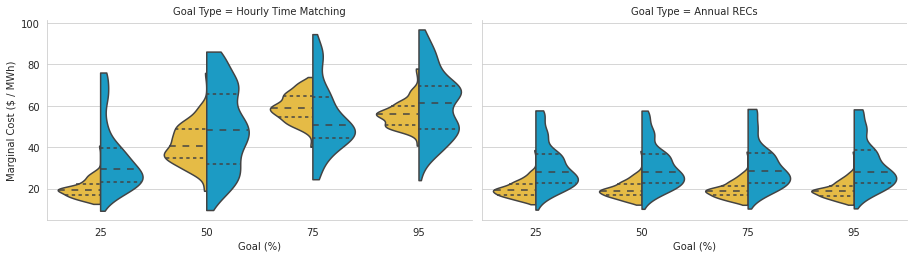

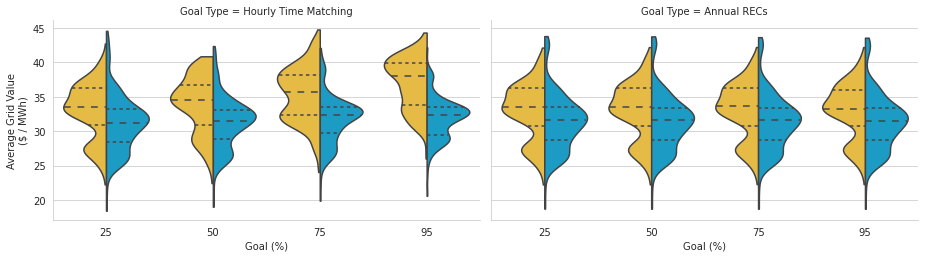

In [265]:
# Original
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)

sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'marginal_cost_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'marginal_cost_mwh'].quantile(0.95)
        datas.append(data.loc[goal_mask & (data['marginal_cost_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','marginal_cost_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV','Wind'])

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='marginal_cost_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Marginal Cost ($ / MWh)')

data = df[['region','tech','goal_type','goal_pct', 'grid_value_per_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'grid_value_per_mwh'].quantile(1)
        datas.append(data.loc[goal_mask & (data['grid_value_per_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','grid_value_per_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV', 'Wind'])

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='grid_value_per_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

# g.set(ylim=(0,600))
g.set_xlabels('Goal (%)')
g.set_ylabels('Average Grid Value\n($ / MWh)')

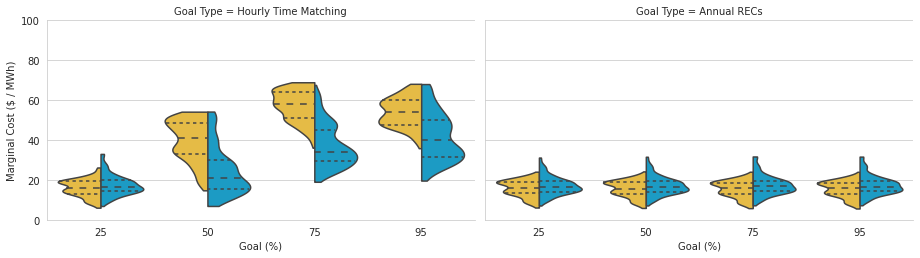

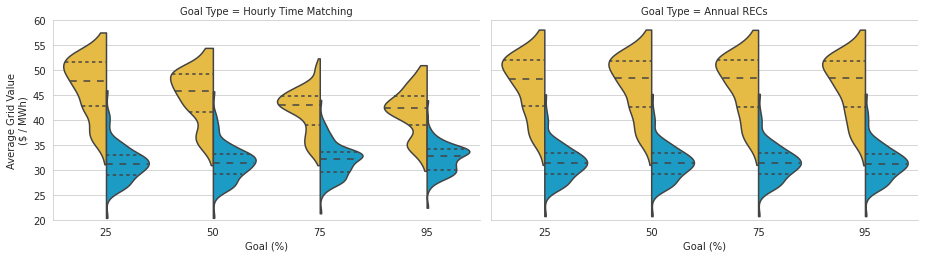

In [4]:
# New
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results', 'best_by_region',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')
                        
# --- Sort Systems to Keep best by State ---
df.sort_values(opt_vars[0], inplace=True)

sns.set_style('whitegrid')

data = df[['region','tech','goal_type','goal_pct', 'marginal_cost_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'marginal_cost_mwh'].quantile(0.95)
        datas.append(data.loc[goal_mask & (data['marginal_cost_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','marginal_cost_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV','Wind'])

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='marginal_cost_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

g.set(ylim=(0,100))
g.set_xlabels('Goal (%)')
g.set_ylabels('Marginal Cost ($ / MWh)')

data = df[['region','tech','goal_type','goal_pct', 'grid_value_per_mwh']]

datas = []
for goal_type in set(data['goal_type']):
    for goal_pct in set(data['goal_pct']):
        goal_mask = (data['goal_type'] == goal_type) & (data['goal_pct'] == goal_pct)
        q = data.loc[goal_mask, 'grid_value_per_mwh'].quantile(1)
        datas.append(data.loc[goal_mask & (data['grid_value_per_mwh'] <= q)])
data = pd.concat(datas, axis='rows')

rename_dict = {'hourly_energy':'Hourly Time Matching', 'annual_recs':'Annual RECs'}
data['goal_type'] = data['goal_type'].map(rename_dict)
data.columns = ['region','Tech','Goal Type', 'goal_pct','grid_value_per_mwh']
tech_dict = {'pv':'PV', 'wind':'Wind'}
data['Tech'] = data['Tech'].map(tech_dict)

data['Goal Type'] = pd.Categorical(data['Goal Type'], ['Hourly Time Matching', 'Annual RECs'])
data.Tech = pd.Categorical(data.Tech, ['PV', 'Wind'])

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

g = sns.catplot(x='goal_pct', y='grid_value_per_mwh',
                hue='Tech', col='Goal Type', inner='quart', 
               data=data, kind='violin', split=True, legend=False,
               height=3.5, aspect=1.8, cut=0, scale='width')

g.set(ylim=(20,60))
g.set_xlabels('Goal (%)')
g.set_ylabels('Average Grid Value\n($ / MWh)')

In [293]:
# Original
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

grouped_orig = results.groupby(['tech','goal_type','goal_pct'], as_index=False)\
                [['adjusted_installed_cost','annual_energy','marginal_cost_mwh','grid_value_per_mwh','lifetime_cambium_co2_rate_lrmer_mwh']].mean()
grouped_orig.goal_type = pd.Categorical(grouped_orig.goal_type, ['annual_recs','hourly_energy'])
grouped_orig.tech = pd.Categorical(grouped_orig.tech, ['pv','wind'])

grouped_orig.sort_values(['goal_type','tech','goal_pct'], inplace=True)
grouped_orig[['adjusted_installed_cost','annual_energy']] /= 1e6

rename_dict = {'hourly_energy':'Hourly Energy', 'annual_recs':'Annual RECs'}
grouped_orig['goal_type'] = grouped_orig['goal_type'].map(rename_dict)
tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped_orig['tech'] = grouped_orig['tech'].map(tech_dict)

grouped_orig.reset_index(inplace=True, drop=True)

x_1 = grouped_orig.groupby(['tech','goal_type'], as_index=False)[['adjusted_installed_cost', 'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(1)*100).round(decimals=1))
x_2 = grouped_orig.groupby(['tech','goal_type'], as_index=False)[['adjusted_installed_cost', 'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(2)*100).round(decimals=1))
x_3 = grouped_orig.groupby(['tech','goal_type'], as_index=False)[['adjusted_installed_cost', 'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(3)*100).round(decimals=1))

x_c = pd.concat([x_1, x_2, x_3], axis=1)
colnames_new = [[f"change_adjusted_installed_cost_{i+1}", f"change_grid_value_per_mwh_{i+1}", f"change_lifetime_cambium_co2_rate_lrmer_mwh_{i+1}"] for i in range(3)]
colnames_new = [item for sublist in colnames_new for item in sublist]
x_c.columns = colnames_new

x_c = pd.concat([x_1.loc[x_c.isnull().apply(sum, axis=1) >= 6],\
           x_2.loc[(x_c.isnull().apply(sum, axis=1) < 6) & (x_c.isnull().apply(sum, axis=1) >=3)],\
           x_3.loc[x_c.isnull().apply(sum, axis=1) == 0]]).sort_index()
x_c.columns = ['change_adjusted_installed_cost', 'change_grid_value_per_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']

grouped_orig = grouped_orig.merge(x_c, left_index=True, right_index=True)
grouped_orig = grouped_orig[['goal_type', 'goal_pct','tech',  'annual_energy',\
                             'adjusted_installed_cost', 'change_adjusted_installed_cost',\
                             'grid_value_per_mwh', 'change_grid_value_per_mwh',\
                            'lifetime_cambium_co2_rate_lrmer_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']]

grouped_orig[['grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']] = grouped_orig[['grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].round(decimals=2)
grouped_orig[['annual_energy', 'adjusted_installed_cost', 'change_adjusted_installed_cost',\
              'change_grid_value_per_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']] = grouped_orig[['annual_energy', 'adjusted_installed_cost', 'change_adjusted_installed_cost', 'change_grid_value_per_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']].round(decimals=0)

grouped_orig.rename(columns = {'tech': 'Tech', 
                               'goal_type': 'Goal Type',
                               'goal_pct': 'Goal %',
                               'adjusted_installed_cost': 'Adjusted Installed Cost (mill. $)',
                               'change_adjusted_installed_cost': "Change", 
                               'annual_energy': 'Annual Energy Production (GWh)',
                               'marginal_cost_mwh': 'Marginal Cost ($/MWh)',
                               'grid_value_per_mwh': 'Grid Value ($/MWh)',
                               'change_grid_value_per_mwh': "Change",
                               'lifetime_cambium_co2_rate_lrmer_mwh': 'Avoided CO2 (kg / MWh)', 
                               'change_lifetime_cambium_co2_rate_lrmer_mwh': "Change"}, inplace=True)
grouped_orig

Goal Type  Goal %  Tech  Annual Energy Production (GWh)  \
0     Annual RECs      25    PV                            25.0   
1     Annual RECs      50    PV                            50.0   
2     Annual RECs      75    PV                            75.0   
3     Annual RECs      95    PV                            94.0   
4     Annual RECs      25  Wind                            27.0   
5     Annual RECs      50  Wind                            52.0   
6     Annual RECs      75  Wind                            77.0   
7     Annual RECs      95  Wind                            97.0   
8   Hourly Energy      25    PV                            26.0   
9   Hourly Energy      50    PV                            61.0   
10  Hourly Energy      75    PV                            96.0   
11  Hourly Energy      95    PV                           203.0   
12  Hourly Energy      25  Wind                            28.0   
13  Hourly Energy      50  Wind                            74.0   
14  Hourly Energy      75  Wind                           148.0   
15  Hourly Energy      95  Wind                           362.0   

    Adjusted Installed Cost (mill. $)  Change  Grid Value ($/MWh)  Change  \
0                                19.0     NaN               32.82     NaN   
1                                37.0    97.0               32.85     0.0   
2                                55.0   193.0               32.88     0.0   
3                                69.0   269.0               32.86     0.0   
4                                29.0     NaN               30.90     NaN   
5                                55.0    92.0               30.91     0.0   
6                                81.0   183.0               30.91     0.0   
7                               101.0   254.0               30.88    -0.0   
8                                20.0     NaN               32.89     NaN   
9                                69.0   255.0               33.75     3.0   
10                              131.0   571.0               35.16     7.0   
11                              293.0  1403.0               36.84    12.0   
12                               39.0     NaN               30.77     NaN   
13                              151.0   288.0               31.03     1.0   
14                              357.0   817.0               31.43     2.0   
15                              975.0  2403.0               31.73     3.0   

    Avoided CO2 (kg / MWh)  Change  
0                   290.19     NaN  
1                   290.24     0.0  
2                   290.18    -0.0  
3                   290.29     0.0  
4                   369.14     NaN  
5                   369.20     0.0  
6                   369.24     0.0  
7                   369.25     0.0  
8                   290.12     NaN  
9                   299.07     3.0  
10                  320.89    11.0  
11                  332.52    15.0  
12                  368.64     NaN  
13                  363.71    -1.0  
14                  361.08    -2.0  
15                  361.79    -2.0

In [294]:
# Original
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results', 'best_by_region',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

grouped_new = results.groupby(['tech','goal_type','goal_pct'], as_index=False)\
                [['adjusted_installed_cost','annual_energy','marginal_cost_mwh','grid_value_per_mwh','lifetime_cambium_co2_rate_lrmer_mwh']].mean()
grouped_new.goal_type = pd.Categorical(grouped_new.goal_type, ['annual_recs','hourly_energy'])
grouped_new.tech = pd.Categorical(grouped_new.tech, ['pv','wind'])

grouped_new.sort_values(['goal_type','tech','goal_pct'], inplace=True)
grouped_new[['adjusted_installed_cost','annual_energy']] /= 1e6

rename_dict = {'hourly_energy':'Hourly Energy', 'annual_recs':'Annual RECs'}
grouped_new['goal_type'] = grouped_new['goal_type'].map(rename_dict)
tech_dict = {'pv':'PV', 'wind':'Wind'}
grouped_new['tech'] = grouped_new['tech'].map(tech_dict)

grouped_new.reset_index(inplace=True, drop=True)

x_1 = grouped_new.groupby(['tech','goal_type'], as_index=False)[['adjusted_installed_cost', 'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(1)*100).round(decimals=1))
x_2 = grouped_new.groupby(['tech','goal_type'], as_index=False)[['adjusted_installed_cost', 'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(2)*100).round(decimals=1))
x_3 = grouped_new.groupby(['tech','goal_type'], as_index=False)[['adjusted_installed_cost', 'grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].apply(lambda x: (x.pct_change(3)*100).round(decimals=1))

x_c = pd.concat([x_1, x_2, x_3], axis=1)
colnames_new = [[f"change_adjusted_installed_cost_{i+1}", f"change_grid_value_per_mwh_{i+1}", f"change_lifetime_cambium_co2_rate_lrmer_mwh_{i+1}"] for i in range(3)]
colnames_new = [item for sublist in colnames_new for item in sublist]
x_c.columns = colnames_new

x_c = pd.concat([x_1.loc[x_c.isnull().apply(sum, axis=1) >= 6],\
           x_2.loc[(x_c.isnull().apply(sum, axis=1) < 6) & (x_c.isnull().apply(sum, axis=1) >=3)],\
           x_3.loc[x_c.isnull().apply(sum, axis=1) == 0]]).sort_index()
x_c.columns = ['change_adjusted_installed_cost', 'change_grid_value_per_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']

grouped_new = grouped_new.merge(x_c, left_index=True, right_index=True)
grouped_new = grouped_new[['goal_type', 'goal_pct','tech',  'annual_energy',\
                             'adjusted_installed_cost', 'change_adjusted_installed_cost',\
                             'grid_value_per_mwh', 'change_grid_value_per_mwh',\
                            'lifetime_cambium_co2_rate_lrmer_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']]

grouped_new[['grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']] = grouped_new[['grid_value_per_mwh', 'lifetime_cambium_co2_rate_lrmer_mwh']].round(decimals=2)
grouped_new[['annual_energy', 'adjusted_installed_cost', 'change_adjusted_installed_cost',\
              'change_grid_value_per_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']] = grouped_new[['annual_energy', 'adjusted_installed_cost', 'change_adjusted_installed_cost', 'change_grid_value_per_mwh', 'change_lifetime_cambium_co2_rate_lrmer_mwh']].round(decimals=0)

grouped_new.rename(columns = {'tech': 'Tech', 
                               'goal_type': 'Goal Type',
                               'goal_pct': 'Goal %',
                               'adjusted_installed_cost': 'Adjusted Installed Cost (mill. $)',
                               'change_adjusted_installed_cost': "Change", 
                               'annual_energy': 'Annual Energy Production (GWh)',
                               'marginal_cost_mwh': 'Marginal Cost ($/MWh)',
                               'grid_value_per_mwh': 'Grid Value ($/MWh)',
                               'change_grid_value_per_mwh': "Change",
                               'lifetime_cambium_co2_rate_lrmer_mwh': 'Avoided CO2 (kg / MWh)', 
                               'change_lifetime_cambium_co2_rate_lrmer_mwh': "Change"}, inplace=True)
grouped_new

Goal Type  Goal %  Tech  Annual Energy Production (GWh)  \
0     Annual RECs      25    PV                            25.0   
1     Annual RECs      50    PV                            50.0   
2     Annual RECs      75    PV                            75.0   
3     Annual RECs      95    PV                            94.0   
4     Annual RECs      25  Wind                            28.0   
5     Annual RECs      50  Wind                            53.0   
6     Annual RECs      75  Wind                            78.0   
7     Annual RECs      95  Wind                            98.0   
8   Hourly Energy      25    PV                            26.0   
9   Hourly Energy      50    PV                            60.0   
10  Hourly Energy      75    PV                            98.0   
11  Hourly Energy      95    PV                           202.0   
12  Hourly Energy      25  Wind                            28.0   
13  Hourly Energy      50  Wind                            63.0   
14  Hourly Energy      75  Wind                           126.0   
15  Hourly Energy      95  Wind                           286.0   

    Adjusted Installed Cost (mill. $)  Change  Grid Value ($/MWh)  Change  \
0                                19.0     NaN               46.68     NaN   
1                                37.0    96.0               46.64    -0.0   
2                                55.0   193.0               46.63    -0.0   
3                                69.0   269.0               46.58    -0.0   
4                                20.0     NaN               31.07     NaN   
5                                37.0    89.0               31.07    -0.0   
6                                55.0   178.0               31.07    -0.0   
7                                69.0   249.0               31.05    -0.0   
8                                20.0     NaN               46.35     NaN   
9                                70.0   255.0               44.47    -4.0   
10                              134.0   582.0               41.57   -10.0   
11                              304.0  1449.0               41.34   -11.0   
12                               20.0     NaN               30.87     NaN   
13                               68.0   242.0               31.02     0.0   
14                              199.0   898.0               31.52     2.0   
15                              512.0  2472.0               32.03     4.0   

    Avoided CO2 (kg / MWh)  Change  
0                   342.22     NaN  
1                   342.31     0.0  
2                   342.53     0.0  
3                   342.48     0.0  
4                   353.87     NaN  
5                   353.88     0.0  
6                   353.88     0.0  
7                   353.84    -0.0  
8                   343.35     NaN  
9                   357.14     4.0  
10                  366.36     7.0  
11                  363.50     6.0  
12                  353.79     NaN  
13                  351.05    -1.0  
14                  348.59    -2.0  
15                  348.50    -2.0

In [299]:
grouped = grouped_orig[['Goal Type','Goal %', 'Tech', 'Adjusted Installed Cost (mill. $)',\
                        'Grid Value ($/MWh)', 'Avoided CO2 (kg / MWh)']].merge(grouped_new[['Goal Type','Goal %', 'Tech', 'Adjusted Installed Cost (mill. $)', \
                                                                                            'Grid Value ($/MWh)', 'Avoided CO2 (kg / MWh)']], on =['Goal Type','Goal %', 'Tech'], suffixes = ('_orig', '_new'))
grouped['Change_Adjusted_Installed_Cost'] = ((grouped['Adjusted Installed Cost (mill. $)_new'] - grouped['Adjusted Installed Cost (mill. $)_orig'])/grouped['Adjusted Installed Cost (mill. $)_orig'])*100
grouped['Change_Grid_Value'] = ((grouped['Grid Value ($/MWh)_new'] - grouped['Grid Value ($/MWh)_orig'])/grouped['Grid Value ($/MWh)_orig'])*100
grouped['Change_Emissions'] = ((grouped['Avoided CO2 (kg / MWh)_new'] - grouped['Avoided CO2 (kg / MWh)_orig'])/grouped['Avoided CO2 (kg / MWh)_orig'])*100

grouped[['Goal Type','Goal %', 'Tech', 'Change_Adjusted_Installed_Cost', 'Change_Grid_Value', 'Change_Emissions']]

Goal Type  Goal %  Tech  Change_Adjusted_Installed_Cost  \
0     Annual RECs      25    PV                        0.000000   
1     Annual RECs      50    PV                        0.000000   
2     Annual RECs      75    PV                        0.000000   
3     Annual RECs      95    PV                        0.000000   
4     Annual RECs      25  Wind                      -31.034483   
5     Annual RECs      50  Wind                      -32.727273   
6     Annual RECs      75  Wind                      -32.098765   
7     Annual RECs      95  Wind                      -31.683168   
8   Hourly Energy      25    PV                        0.000000   
9   Hourly Energy      50    PV                        1.449275   
10  Hourly Energy      75    PV                        2.290076   
11  Hourly Energy      95    PV                        3.754266   
12  Hourly Energy      25  Wind                      -48.717949   
13  Hourly Energy      50  Wind                      -54.966887   
14  Hourly Energy      75  Wind                      -44.257703   
15  Hourly Energy      95  Wind                      -47.487179   

    Change_Grid_Value  Change_Grid_Value  
0           17.929632          17.929632  
1           17.940325          17.940325  
2           18.040527          18.040527  
3           17.978573          17.978573  
4           -4.136642          -4.136642  
5           -4.149512          -4.149512  
6           -4.159896          -4.159896  
7           -4.173324          -4.173324  
8           18.347580          18.347580  
9           19.416859          19.416859  
10          14.169965          14.169965  
11           9.316733           9.316733  
12          -4.028320          -4.028320  
13          -3.480795          -3.480795  
14          -3.459067          -3.459067  
15          -3.673402          -3.673402

## Optimal System Config

In [300]:
# Original
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')


system_configs = df[['state','tech','goal_type','goal_pct','adjusted_installed_cost',
                         'system_capacity',
                          'turbine_class','wind_turbine_hub_ht',
                          'subarray1_azimuth','subarray1_tilt',
                          'dc_ac_ratio',
                          'desired_power','desired_capacity']]
system_configs['batt_duration'] = system_configs['desired_capacity'] / system_configs['desired_power']

states = system_configs.copy()
states = states.loc[states['state'].isin(['CA','TX'])]
states = states.loc[states['goal_type'] == 'hourly_energy']
states.sort_values(['state','goal_pct','adjusted_installed_cost'], inplace=True, ascending=True)
states.drop_duplicates(subset=['state','goal_pct'], inplace=True)

states['adjusted_installed_cost'] /= 1e6
states[['system_capacity','desired_capacity','desired_power']] /= 1e3
states

state  tech      goal_type  goal_pct  adjusted_installed_cost  \
2851    CA    pv  hourly_energy        25                15.084981   
3207    CA    pv  hourly_energy        50                41.730832   
3563    CA    pv  hourly_energy        75                90.546764   
3919    CA    pv  hourly_energy        95               139.991039   
247     TX  wind  hourly_energy        25                12.648580   
603     TX  wind  hourly_energy        50                24.880825   
3803    TX    pv  hourly_energy        75                86.233875   
4159    TX    pv  hourly_energy        95               136.721709   

      system_capacity  turbine_class  wind_turbine_hub_ht  subarray1_azimuth  \
2851        10.133777            NaN                  NaN         181.589913   
3207        19.873309            NaN                  NaN         178.256548   
3563        35.996174            NaN                  NaN         182.018054   
3919        46.736803            NaN                  NaN         180.854135   
247          7.356297            6.0            98.366458                NaN   
603         16.325532            6.0            98.252278                NaN   
3803        33.893458            NaN                  NaN         181.838446   
4159        53.669319            NaN                  NaN         180.467618   

      subarray1_tilt  dc_ac_ratio  desired_power  desired_capacity  \
2851       41.238905     1.173685   0.000000e+00      3.000000e-03   
3207       35.155864     1.199595   8.213006e+00      3.285202e+01   
3563       34.806491     1.198061   2.488855e+01      9.955419e+01   
3919       35.542936     1.199906   4.707532e+01      1.883013e+02   
247              NaN          NaN   0.000000e+00      3.000000e-03   
603              NaN          NaN   3.841033e-12      1.536413e-11   
3803       31.846750     1.198729   2.885257e+01      1.154103e+02   
4159       32.284833     1.199324   4.597417e+01      1.838967e+02   

      batt_duration  
2851            inf  
3207            4.0  
3563            4.0  
3919            4.0  
247             inf  
603             4.0  
3803            4.0  
4159            4.0

In [301]:
# New
dfs = []

# --- Define Optimization Variables ---
aggregate_region = 'pca'
opt_vars = ['adjusted_installed_cost']
scenarios = ['StdScen20_MidCase']
techs = ['wind','pv']
constraints = ['hourly_energy','annual_recs']
constraint_pcts = [25,50,75,95]

for opt_var in opt_vars:
    for scenario in scenarios:
        for tech in techs:
            for constraint in constraints:
                for constraint_pct in constraint_pcts:
                    file = f"{aggregate_region}_best_{tech}_{scenario}_{opt_var}_constraint_{constraint}_{constraint_pct}.pkl"
                    fp = os.path.join('results', 'best_by_region',file)
                    df = pd.read_pickle(fp)
                    df['goal_type'] = constraint
                    df['goal_pct'] = constraint_pct
                    dfs.append(df)


results = pd.concat(dfs, axis='rows')
results.reset_index(drop=True, inplace=True)

# --- Map on States ---
hierarchy = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
hierarchy.rename({'pca':'region'}, axis='columns', inplace=True)
df = results.merge(hierarchy[['region','state']], on='region', how='left')


system_configs = df[['state','tech','goal_type','goal_pct','adjusted_installed_cost',
                         'system_capacity',
                          'turbine_class','wind_turbine_hub_ht',
                          'subarray1_azimuth','subarray1_tilt',
                          'dc_ac_ratio',
                          'desired_power','desired_capacity']]
system_configs['batt_duration'] = system_configs['desired_capacity'] / system_configs['desired_power']

states = system_configs.copy()
states = states.loc[states['state'].isin(['CA','TX'])]
states = states.loc[states['goal_type'] == 'hourly_energy']
states.sort_values(['state','goal_pct','adjusted_installed_cost'], inplace=True, ascending=True)
states.drop_duplicates(subset=['state','goal_pct'], inplace=True)

states['adjusted_installed_cost'] /= 1e6
states[['system_capacity','desired_capacity','desired_power']] /= 1e3
states

state  tech      goal_type  goal_pct  adjusted_installed_cost  \
2883    CA    pv  hourly_energy        25                15.059058   
359     CA  wind  hourly_energy        50                33.509031   
3564    CA    pv  hourly_energy        75                93.876767   
3920    CA    pv  hourly_energy        95               157.480909   
207     TX  wind  hourly_energy        25                12.648580   
603     TX  wind  hourly_energy        50                24.880825   
3807    TX    pv  hourly_energy        75                88.702635   
4163    TX    pv  hourly_energy        95               146.373053   

      system_capacity  turbine_class  wind_turbine_hub_ht  subarray1_azimuth  \
2883        10.132224            NaN                  NaN         174.433409   
359         19.040591            6.0            99.859814                NaN   
3564        35.396008            NaN                  NaN         178.242200   
3920        59.483195            NaN                  NaN         177.436104   
207          7.356297            6.0            98.366458                NaN   
603         16.325532            6.0            98.252278                NaN   
3807        36.116652            NaN                  NaN         179.954773   
4163        57.551727            NaN                  NaN         175.977936   

      subarray1_tilt  dc_ac_ratio  desired_power  desired_capacity  \
2883       32.736451     1.193511   0.000000e+00      0.000000e+00   
359              NaN          NaN   2.978555e+00      1.191422e+01   
3564       34.847450     1.198573   2.763562e+01      1.105425e+02   
3920       34.816769     1.198010   4.644424e+01      1.857770e+02   
207              NaN          NaN   0.000000e+00      3.000000e-03   
603              NaN          NaN   3.841033e-12      1.536413e-11   
3807       32.359701     1.197782   2.972485e+01      1.188994e+02   
4163       32.109958     1.198363   5.103930e+01      2.041572e+02   

      batt_duration  
2883            NaN  
359             4.0  
3564            4.0  
3920            4.0  
207             inf  
603             4.0  
3807            4.0  
4163            4.0

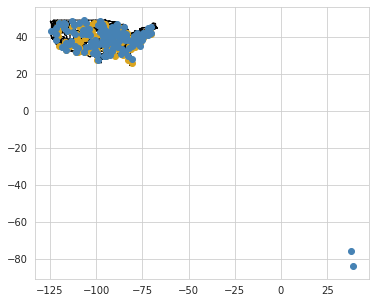

In [316]:
reeds_regions = gpd.read_file(os.path.join('geography', "ReEDS_Resource_Regions.shp"))
reeds_regions.dissolve('pca')

best_pv_sites = pd.read_csv(os.path.join('data', 'reV_resource_supply_curves', 'best_supply_curve_pca_pv.csv'))
best_pv_sites = gpd.GeoDataFrame(best_pv_sites, geometry=gpd.points_from_xy(best_pv_sites.lon, best_pv_sites.lat))
best_wind_sites = pd.read_csv(os.path.join('data', 'reV_resource_supply_curves', 'best_supply_curve_pca_wind.csv'))
best_wind_sites = gpd.GeoDataFrame(best_wind_sites, geometry=gpd.points_from_xy(best_wind_sites.lon, best_wind_sites.lat))


ax = reeds_regions.plot(color='white', edgecolor='black', figsize=(9, 5))
best_pv_sites.plot(ax=ax, color='goldenrod')
best_wind_sites.plot(ax=ax, color='steelblue')

plt.show()

In [323]:
best_wind_sites.loc[best_wind_sites.lon > -75]

Unnamed: 0  index   pca  tech   mean_cf  total_lcoe  capacity   dist_mi  \
28           28   28.0  p126  wind  0.446672   25.872175  130.0536  7.054303   
29           29   29.0  p127  wind  0.543134   21.043466  114.2100  5.120136   
30           30   30.0  p128  wind  0.519260   22.547287    3.4263  0.121469   
31           31   31.0  p129  wind  0.497212   23.002003  179.2368  0.994748   
33           33   33.0  p130  wind  0.516291   22.497477  100.7964  3.864826   
34           34   34.0  p131  wind  0.509141   22.138228  114.6960  0.068259   
35           35   35.0  p132  wind  0.489165   23.397801   67.2624  0.339223   
36           36   36.0  p133  wind  0.493893   22.670522    8.8209  3.092360   
37           37   37.0  p134  wind  0.552851   21.581010  119.1672  8.921367   
132          17    NaN  p114  wind       NaN         NaN       NaN       NaN   
133          28    NaN  p124  wind       NaN         NaN       NaN       NaN   

     rank_mean_cf  rank_total_lcoe  rank_dist_mi  rank     lon     lat  \
28            1.0              1.0           1.0   1.0 -74.367  39.826   
29            1.0              1.0           8.0   1.0 -74.504  42.032   
30            3.0              2.0           1.0   1.0 -72.003  41.020   
31            2.0              2.0           1.0   1.0 -71.783  44.925   
33            4.0              2.0           4.0   1.0 -72.095  43.006   
34            1.0              1.0           1.0   1.0 -70.504  41.734   
35            2.0              2.0           2.0   1.0 -73.213  41.875   
36            3.0              1.0           6.0   1.0 -71.618  41.572   
37            2.0              1.0           3.0   1.0 -70.118  45.466   
132           NaN              NaN           NaN   NaN  39.201 -84.253   
133           NaN              NaN           NaN   NaN  37.664 -75.727   

                 point                    geometry  
28   (-74.367, 39.826)  POINT (-74.36700 39.82600)  
29   (-74.504, 42.032)  POINT (-74.50400 42.03200)  
30    (-72.003, 41.02)  POINT (-72.00300 41.02000)  
31   (-71.783, 44.925)  POINT (-71.78300 44.92500)  
33   (-72.095, 43.006)  POINT (-72.09500 43.00600)  
34   (-70.504, 41.734)  POINT (-70.50400 41.73400)  
35   (-73.213, 41.875)  POINT (-73.21300 41.87500)  
36   (-71.618, 41.572)  POINT (-71.61800 41.57200)  
37   (-70.118, 45.466)  POINT (-70.11800 45.46600)  
132  (-84.253, 39.201)  POINT (39.20100 -84.25300)  
133  (-75.727, 37.664)  POINT (37.66400 -75.72700)

In [322]:
xx = pd.read_csv(os.path.join('data', 'reV_resource_supply_curves', 'best_sites_uwind_new.csv'))
xx.loc[xx.reeds_ba.isin(['p114', 'p124'])]

tech      location reeds_ba  rank  sc_in_ba  rank_total_lcoe  \
960  wind  Butler, Ohio     p114     3         1                1   

     rank_dist_mi  rank_mean_cf  res_longitude  res_latitude  ... cnty_fips  \
960             1             1       39.45618    -84.844635  ...     18047   

    sc_point_gid transmission_multiplier  trans_gid  trans_capacity  \
960        44733                    1.45      27961           390.0   

     trans_type  trans_cap_cost   dist_mi      lcot  total_lcoe  
960   TransLine     24623.95313  1.998054  0.419715    22.67262  

[1 rows x 36 columns]

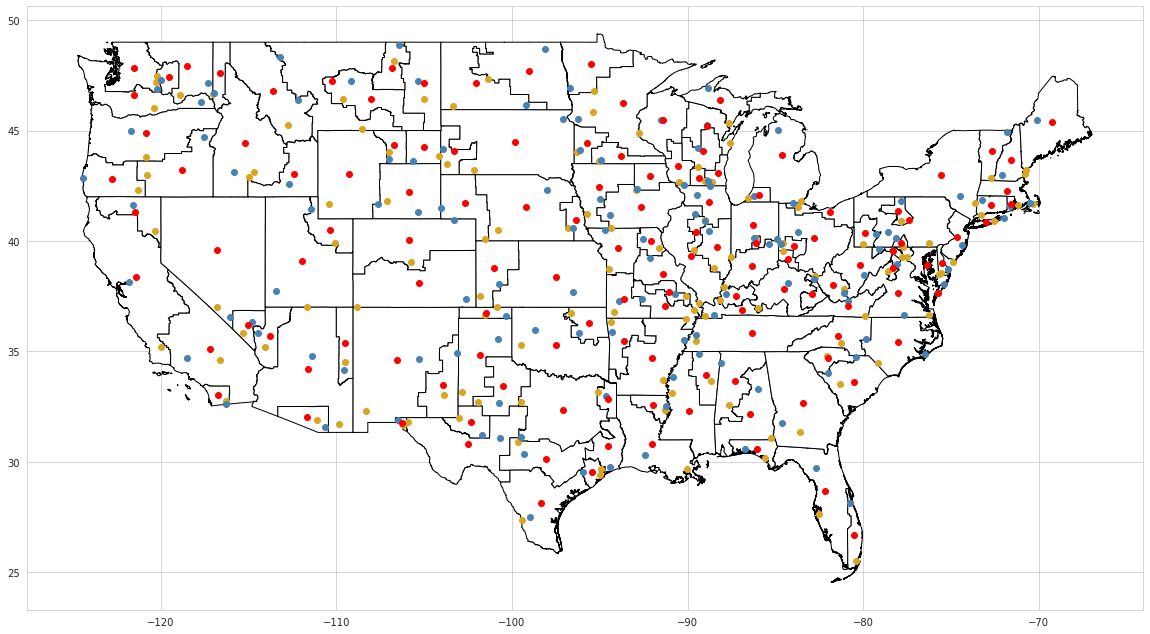

In [338]:
reeds_regions = gpd.read_file(os.path.join('geography', "ReEDS_Resource_Regions.shp"))
reeds_regions = reeds_regions.dissolve('pca')

best_pv_sites = pd.read_csv(os.path.join('data', 'reV_resource_supply_curves', 'best_supply_curve_pca_pv.csv'))
best_pv_sites = gpd.GeoDataFrame(best_pv_sites, geometry=gpd.points_from_xy(best_pv_sites.lon, best_pv_sites.lat))
best_wind_sites = pd.read_csv(os.path.join('data', 'reV_resource_supply_curves', 'best_supply_curve_pca_wind.csv'))
best_wind_sites = gpd.GeoDataFrame(best_wind_sites, geometry=gpd.points_from_xy(best_wind_sites.lon, best_wind_sites.lat))

ax = reeds_regions.plot(color='white', edgecolor='black', figsize=(20, 15))
best_pv_sites.loc[best_pv_sites.lon < 0].plot(ax=ax, color='goldenrod')
best_wind_sites.loc[best_wind_sites.lon < 0].plot(ax=ax, color='steelblue')
gpd.GeoDataFrame({'geometry': reeds_regions.centroid}).plot(ax=ax, color='red')

plt.show()